# loop on twin color pairs  with multi colors

- author Sylvie Dagoret-Campagne
- creation date 2024-07-26
- affiliation : IJCLab
- Kernel **w_2024_16**

** Run LoopTwinSource before this**
Must do quick run


In [1]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [4]:
transform = AsinhStretch() + PercentileInterval(99.)

In [5]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240513/w_2024_20/PREOPS-5146' # test this one today 2024/06/22

collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

## Definition of functions used

In [6]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [7]:
def closestvisit(df1,df2):
    """
    This function associate pairs of closest observation for photmetry

    input : the 2 dataframes (first to one for which one want to find the closest obs in dtaframe 2)
    output : the dataframe of similar format as the first one having columns on nightobs , visit time, dt from second dataframe)
    """
    d1 =df1.copy(deep=True)
    d2 =df2.copy(deep=True)
    all_samples = []
    df = pd.DataFrame(index=d1.index,columns=["nightObs2","visit2","time2","deltat"])
    for key in d1.index:

        nightObs = key[0]
        time1 = d1.loc[key]["time"]
        d2["dt"] = np.abs(d2["time"]-time1)
        d2["Dt"] = d2["time"]-time1
        cut_sel = (d2["dt"] == d2["dt"].min()) #& (d2["nightObs"] == nightObs)
        sample = d2[cut_sel]
        #df.iloc[key] = [sample.index[0][0],sample.index[0][1],sample["time"].values[0],sample['dt'].values[0]]
        df.loc[key]["nightObs2"] = sample.index[0][0]
        df.loc[key]["visit2"] = sample.index[0][1]
        df.loc[key]["time2"] = sample["time"].values[0]
        df.loc[key]["deltat"] = pd.to_timedelta(sample["Dt"].values[0], unit="s").total_seconds()
        all_samples.append(sample)

    # select observations during the same night
    df_back = df.copy(deep=True)
    flag_sel = []
    for key in df_back.index:
        nightObs = key[0]
        nightObs2 = df_back.loc[key]["nightObs2"]
        flag_sel.append(nightObs == nightObs2)
    df = df[flag_sel]
    return df

In [8]:
def getcutoutandimage(visitId,df_selectedvisits):
    """
    visitId : the calexp where are the two stars
    df_selectedvisits : the list of all sources and visit of the main targeted star
    """

    row_source = df_selectedvisits[df_selectedvisits.visit == visitId].iloc[0]  
    band = row_source['band']

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)   
    src_cat = butler.get('sourceTable',**dataId, collections=collections)

    #select on star
    #src_cat = src_cat[(src_cat["extendedness"]==0) & (src_cat["parentSourceId"] == 0) ]
    #src_cat = src_cat[src_cat["extendedness"]==0 ]

    x1 = row_source['x_x']
    y1 = row_source['y_x']
    ra1= row_source['ra_x']
    dec1= row_source['dec_x']
    psfMag1  = row_source['psfMag_x']  
    psfSigma1 = row_source['psfSigma_x']
    psfMagDiffMmag1 = row_source['psfMagDiffMmag_x'] 
    apFlux_50_0_instFlux1 = row_source['apFlux_50_0_instFlux_x']
    apFlux_50_0_instFluxErr1 = row_source['apFlux_50_0_instFluxErr_x']


    x2 = row_source['x_y']
    y2 = row_source['y_y']
    ra2= row_source['ra_y']
    dec2= row_source['dec_y']
    psfMag2  = row_source['psfMag_y']  
    psfSigma2 = row_source['psfSigma_y']
    psfMagDiffMmag2 = row_source['psfMagDiffMmag_y'] 
    apFlux_50_0_instFlux2 = row_source['apFlux_50_0_instFlux_y']
    apFlux_50_0_instFluxErr2 = row_source['apFlux_50_0_instFluxErr_y']

    
    # searcch the neighbouring stars
    #separation = find_neighbourg(ra_target,dec_target,src_cat)
    #src_cat["sep"] = separation


    spherePointCenter = lsst.geom.SpherePoint(ra1*lsst.geom.degrees, dec1*lsst.geom.degrees)
    spt = lsst.geom.SpherePoint(ra2*lsst.geom.degrees, dec2*lsst.geom.degrees)
    ang = spherePointCenter.separation(spt)
    ang_arcsec = ang.asArcseconds()
    
   
    x0 = (x1+x2)/2.
    y0 = (y1+y2)/2.
    ra0 = (ra1+ra2)/2.
    dec0 = (dec1+dec2)/2.
    

    dx1 = x1-x0
    dy1 = y1-y0
    dx2 = x2-x0
    dy2 = y2-y0
    
    
    boxSize = int(max(np.abs(x1-x2),np.abs(y1-y2)))
    xmin= x0-boxSize
    xmax= x0+boxSize
    ymin= y0-boxSize
    ymax= y0+boxSize
        
    
    minBbox = geom.Point2I(int(x0) - boxSize ,int(y0) - boxSize)
    maxBbox = geom.Point2I(int(x0) + boxSize, int(y0) + boxSize)
    
    srcBbox = geom.Box2I(minBbox, maxBbox)


    row_source['x0'] = x0
    row_source['y0'] = y0
    row_source['xmin'] = xmin
    row_source['ymin'] = ymin
    row_source['xmax'] = xmax
    row_source['ymax'] = ymax
    row_source['ra0'] = ra0
    row_source['dec0'] = dec0

    row_source['x1'] = x1
    row_source['y1'] = y1
    row_source['dx1'] = dx1
    row_source['dy1'] = dy1
    row_source['ra1'] = ra1
    row_source['dec1'] = dec1

    row_source['x2'] = x2
    row_source['y2'] = y2
    row_source['dx2'] = dx2
    row_source['dy2'] = dy2
    row_source['ra2'] = ra2
    row_source['dec2'] = dec2
    
    
    # Make the cutout
    try:
        subimg = afwImage.ExposureF(calexp, srcBbox, afwImage.PARENT, True)
        #subimg2 = calexp.getImage().array[int(ySrc) - boxSize: int(ySrc) + boxSize+1, int(xSrc) - boxSize:int(xSrc) + boxSize+1 ]
        #subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)
        #all_cutout.append(subimgRgb)
        cutout=subimg.image.array
        
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)     
        cutout = None

    df_pair = row_source.to_frame()
    return row_source,cutout



In [9]:
def GetFluxes2StarsTwoBands(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    Extract color difference from two bright object sources.
    band1 : first band tag 
    band2 : second band tag
    dfb1_b2 : pandas dataframe associating visit in band 1 to visit in band 2
    df_selectedvisits_b1: sources for object 1 and 2 in band 1
    df_selectedvisits_b2: sources for object 1 and 2 in band 2
    May plot some calexp cutout for checking
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt","airmassb1","airmassb2",
                                          "x11","y11","x12","y12","x21","y21","x22","y22"])
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 

            airmassb1 = row_pair_b1["airmass_x"] 
            airmassb2 = row_pair_b2["airmass_y"] 

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
            x11 = row_pair_b1["x_x"]
            y11 = row_pair_b1["y_x"]
            
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            x12 = row_pair_b1["x_y"]
            y12 = row_pair_b1["y_y"]
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            x21 = row_pair_b2["x_x"]
            y21 = row_pair_b2["y_x"]
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])
            x22 = row_pair_b2["x_y"]
            y22 = row_pair_b2["y_y"]


            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,
                                           airmassb1,airmassb2,x11,y11,x12,y12,x21,y21,x22,y22]
            entrycount+=1

        
        except Exception as inst:
            #print(type(inst))    # the exception type
            #print(inst.args)     # arguments stored in .args
            print(inst)
            continue
      

        if idx%10 == 0:
            if cutoutb1 is not None and cutoutb2 is not None:
                NROWS = 1
                NCOLS = 2
                fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))
                plotcutout(row_pair_b1,cutoutb1,ax=ax1)
                plotcutout(row_pair_b2,cutoutb2,ax=ax2)
                plt.show()

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)

     # Maximum magnitude in band b1 and band b2
    df_col_b1b2["psfmagmax_s12b1"] = np.fmax(df_col_b1b2["psfMag11"],df_col_b1b2["psfMag12"])
    df_col_b1b2["psfmagmax_s12b2"] = np.fmax(df_col_b1b2["psfMag21"],df_col_b1b2["psfMag22"])

    df_col_b1b2["apmagmax_s12b1"] = np.fmax(df_col_b1b2["apMag11"],df_col_b1b2["apMag12"])
    df_col_b1b2["apmagmax_s12b2"] = np.fmax(df_col_b1b2["apMag21"],df_col_b1b2["apMag22"])
    
    
    return df_col_b1b2


In [10]:
def GetFluxes2StarsTwoBandsNoCutout(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    Extract color difference from two bright object sources.
    band1 : first band tag 
    band2 : second band tag
    dfb1_b2 : pandas dataframe associating visit in band 1 to visit in band 2
    df_selectedvisits_b1: sources for object 1 and 2 in band 1
    df_selectedvisits_b2: sources for object 1 and 2 in band 2
    NO NOT plot some calexp cutout contrary to above function
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt","airmassb1","airmassb2",
                                          "x11","y11","x12","y12","x21","y21","x22","y22"                                         
                                         ])
    
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            #row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            #row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 
            row_pair_b1  = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]  
            row_pair_b2  = df_selectedvisits_b2[df_selectedvisits_b2.visit == visit2].iloc[0]  

            airmassb1 = row_pair_b1["airmass_x"] 
            airmassb2 = row_pair_b2["airmass_y"] 
            
            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]    
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
            x11 = row_pair_b1["x_x"]
            y11 = row_pair_b1["y_x"]
            
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            x12 = row_pair_b1["x_y"]
            y12 = row_pair_b1["y_y"]
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            x21 = row_pair_b2["x_x"]
            y21 = row_pair_b2["y_x"]

            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])
            x22 = row_pair_b2["x_y"]
            y22 = row_pair_b2["y_y"]


            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,airmassb1,airmassb2,
                                           x11,y11,x12,y12,x21,y21,x22,y22]

            entrycount+=1
        except Exception as inst:
            #print(type(inst))    # the exception type
            #print(inst.args)     # arguments stored in .args
            print(inst)
            continue

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # absolute relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)

    # Maximum magnitude in band b1 and band b2
    df_col_b1b2["psfmagmax_s12b1"] = np.fmax(df_col_b1b2["psfMag11"],df_col_b1b2["psfMag12"])
    df_col_b1b2["psfmagmax_s12b2"] = np.fmax(df_col_b1b2["psfMag21"],df_col_b1b2["psfMag22"])

    df_col_b1b2["apmagmax_s12b1"] = np.fmax(df_col_b1b2["apMag11"],df_col_b1b2["apMag12"])
    df_col_b1b2["apmagmax_s12b2"] = np.fmax(df_col_b1b2["apMag21"],df_col_b1b2["apMag22"])
    


    return df_col_b1b2

In [11]:
def closesttimespectrophotom(df_photpair,df_spec):
    """
    Search the closest spectroscopic time for a photometric light curve

    - calculate with assign
    df_spec[["Time"]].assign( ddt = lambda row : np.abs((row["Time"].loc[0].replace(tzinfo=None) - df_photpair["time1"].loc[1]).total_seconds()))
    - calculate with apply two quantities : dt_abs, dt_rel    
    df_spec[["dt_abs","td_rel"]]=df_spec[["Time"]].apply( lambda row : [ np.abs((row["Time"].replace(tzinfo=None) - df_photpair["time1"].loc[1]).total_seconds()),(row["Time"].replace(tzinfo=None) - df_photpair["time1"].loc[1]).total_seconds()],axis=1,result_type='expand')
    """
    d1 =df_photpair.copy(deep=True)
    d2 =df_spec.copy(deep=True)
    all_samples = []
    df = pd.DataFrame(index=d1.index,columns=["time1","time2","deltat"])
    
    # loop on light curve datapoints times
    all_spectro_associated = []
    for key in d1.index:
        # take the time of the first source 
        # remember dt must be small
        tphotometric = df_photpair["time1"].loc[key]
        df_spec_copy = df_spec.copy(deep=True)
        # compute relative and absolute time difference of spectro wrt photmetry
        df_spec_copy[["dt_abs_specphot","td_rel_specphot"]]=df_spec_copy[["Time"]].apply( lambda row : [ np.abs((row["Time"].replace(tzinfo=None) - tphotometric).total_seconds()),(row["Time"].replace(tzinfo=None) - tphotometric ).total_seconds()],axis=1,result_type='expand')
        # find the minimum on absolute time difference between spectro and photometry
        df_spec_sel = df_spec_copy[ df_spec_copy["dt_abs_specphot"] == df_spec_copy["dt_abs_specphot"].min()]
        all_spectro_associated.append(df_spec_sel)

    # merge all datapoint on single dataframe
    df_spec_sel_concat = pd.concat(all_spectro_associated)
    df_spec_sel_concat.reset_index(level=0, inplace=True)

    # set nan if more than 12*3600 seconds outside
    
    return df_spec_sel_concat


## Selected visits

### Spectroscopy

In [12]:
atmfilename = "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy"

In [13]:
specdata = np.load(atmfilename,allow_pickle=True)

In [14]:
df_spec = pd.DataFrame(specdata)
df_spec

DATE-OBS             id  BITPIX  NAXIS  \
0    2023-01-18 02:33:44.320492641+00:00  2023011700238     -64      2   
1    2023-01-18 02:34:27.138506292+00:00  2023011700239     -64      2   
2    2023-01-18 02:43:58.366995924+00:00  2023011700243     -64      2   
3    2023-01-18 02:44:41.368008749+00:00  2023011700244     -64      2   
4    2023-01-18 03:05:13.302506988+00:00  2023011700248     -64      2   
...                                  ...            ...     ...    ...   
3400 2024-04-25 00:39:29.433008754+00:00  2024042400333     -64      2   
3401 2024-04-25 00:55:22.979509527+00:00  2024042400346     -64      2   
3402 2024-04-25 00:56:06.459007458+00:00  2024042400347     -64      2   
3403 2024-04-25 01:02:42.672496953+00:00  2024042400353     -64      2   
3404 2024-04-25 01:03:55.696495445+00:00  2024042400354     -64      2   

      NAXIS1  NAXIS2  EXTEND    TARGET  REDSHIFT    GRATING  ROTANGLE  \
0       1136       3    True  HD185975 -0.000065  holo4_003  0.149105   
1       1137       3    True  HD185975 -0.000065  holo4_003  0.138871   
2       1137       3    True  HD074000  0.000687  holo4_003  0.158534   
3       1136       3    True  HD074000  0.000687  holo4_003  0.166269   
4       1137       3    True  HD185975 -0.000065  holo4_003  0.150002   
...      ...     ...     ...       ...       ...        ...       ...   
3400    1136       3    True   HD38666  0.000364  holo4_003  0.132417   
3401    1137       3    True   HD38666  0.000364  holo4_003  0.143719   
3402    1136       3    True   HD38666  0.000364  holo4_003  0.152534   
3403    1136       3    True  HD185975 -0.000065  holo4_003  0.123265   
3404    1137       3    True  HD185975 -0.000065  holo4_003  0.120606   

           D2CCD  LSHIFT    PARANGLE     TARGETX     TARGETY    LBDA_REF  \
0     187.115733     0.0  139.709895  146.034375  882.149820  619.643455   
1     187.076469     0.0  139.885619  144.051156  882.564567  619.643455   
2     187.119278     0.0 -117.472494  154.842894  861.406704  593.786320   
3     187.050940     0.0 -117.512030  156.686849  860.564566  593.786320   
4     186.942941     0.0  147.543482  144.775638  880.490073  619.643455   
...          ...     ...         ...         ...         ...         ...   
3400  187.117687     0.0  106.711586  100.736892  866.715100  507.125054   
3401  186.998581     0.0  108.185894   99.066008  866.602179  507.125054   
3402  187.185017     0.0  108.253749   98.596563  866.319712  507.125054   
3403  186.981197     0.0 -149.447375  105.342772  879.114013  619.643455   
3404  186.926714     0.0 -149.147539  104.565481  879.477226  619.643455   

        PSF_REG     TRACE_R   MEANFWHM  PIXSHIFT   CHI2_FIT  A2_FIT    AM_FIT  \
0     14.563485   93.783944  10.355760  1.160026  10.840887     0.0  2.094160   
1      0.228823   53.345136  10.918251  0.101144   4.849593     0.0  2.094525   
2      2.191228   58.723003   5.774475  0.652831   1.600393     0.0  1.335267   
3      1.143701   58.383109   6.157839  0.981276   1.446386     0.0  1.332128   
4      2.217877   49.145138   9.333022  1.155172  12.758147     0.0  2.109638   
...         ...         ...        ...       ...        ...     ...       ...   
3400  35.814798   55.728910   7.283025  1.206135  39.555613     0.0  1.754515   
3401   7.542218  125.039285   5.968905  0.678433  70.023121     0.0  1.911344   
3402   5.410127  132.672597   5.363334  1.233295  70.166071     0.0  1.919263   
3403   1.883107   57.491494   7.470839  0.982759   4.166727     0.0  2.123291   
3404   1.069055   56.154553   8.552225  1.018658   4.985706     0.0  2.122822   

     VERSION  CCD_REBIN CONFIG  EXPTIME   AIRMASS        DEC          HA  \
0      3.1.0          2            30.0  2.094160 -87.507430 -221.203268   
1      3.1.0          2            30.0  2.094525 -87.507439 -221.024162   
2      3.1.0          2            30.0  1.335267 -16.286314  -42.985404   
3      3.1.0          2            30.0  1.332128 -16.286290  -42.805858   


In [15]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])
#df_spec["PWV [mm]_x"]

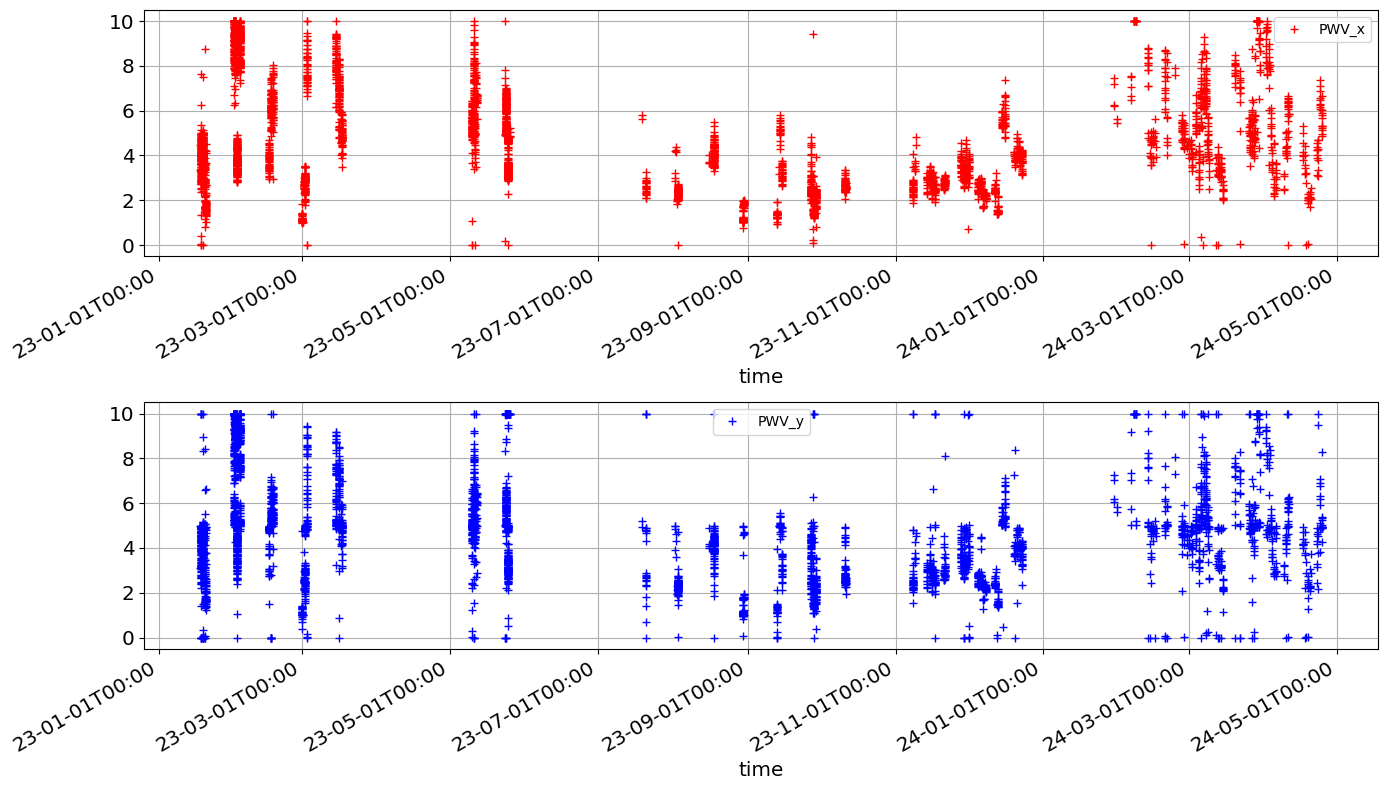

In [16]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8))
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="PWV_x")
df_spec.plot(x="Time",y="PWV [mm]_y",ax=ax2,marker='+',c="b",lw=0.0,grid=True,label="PWV_y")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)
plt.tight_layout()

## Photometry

#### read list of all possible pairs

In [17]:
df_pair = pd.read_csv("all_pairs.csv",index_col=0)
df_pair.head()

objidx1  objidx2     G1_R1     G2_R2     Z1_Y1     Z2_Y2        sep
606     141.0    907.0  0.735042  0.980283 -0.114436       NaN   7.953708
2060    654.0    669.0  0.331201  0.533893  0.007770 -0.191827  10.576831
333     111.0    262.0  0.540740  0.144065 -0.112162  0.005726  16.129314
2152    813.0    950.0  0.864215  1.371627 -0.175939       NaN  16.859074
18       64.0    262.0  0.480447  0.144065 -0.094639  0.005726  18.288013

In [18]:
len(df_pair)

2211

Text(0.5, 1.0, 'Bright sources angular correlation in tract 3864')

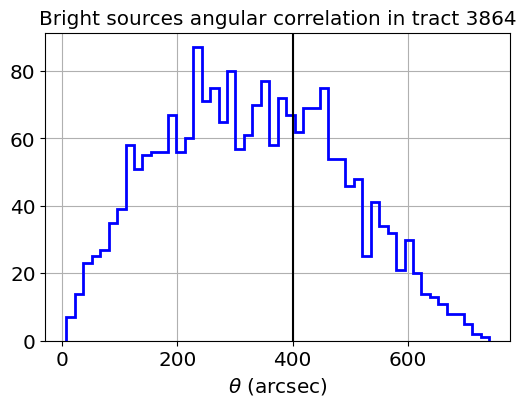

In [19]:
fig,axs = plt.subplots(1,1,figsize=(6,4))
ax1 = axs
df_pair["sep"].hist(bins=50,ax=ax1,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title(f"Bright sources angular correlation in tract {tract}")


### Select the pairs

In [20]:
sep_max = 100.
df_pair = df_pair[df_pair["sep"]<sep_max]

Text(0.5, 1.0, 'Bright sources angular correlation in tract 3864')

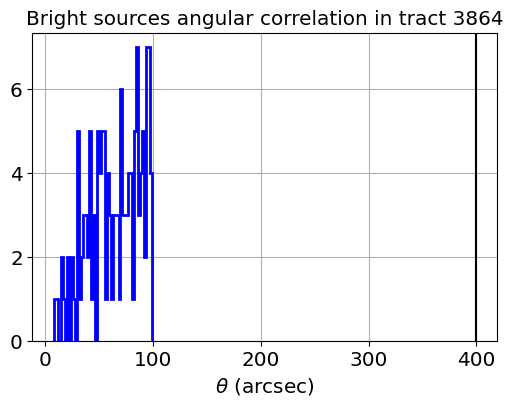

In [21]:
fig,axs = plt.subplots(1,1,figsize=(6,4))
ax1 = axs
df_pair["sep"].hist(bins=50,ax=ax1,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title(f"Bright sources angular correlation in tract {tract}")

## Read pairs

In [22]:
path_input = "data_coloredlightcurvesZ_Y"
if not os.path.exists(path_input):
    print(f"Missing directory {path_input}  ==> Must run notebook LoopTwinSourcesMultiColorLightCurveToFitsfromPairs-Auxtel-ColorZY.ipynb")
    assert False

### Read summary

In [23]:
df_summary = pd.read_csv(os.path.join(path_input,"photompairsummaryZ_Y.csv"),index_col=0)

In [24]:
df_summary

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
0         0.0     141.0     907.0   7.0       0.089904          39.0   
1         1.0     654.0     669.0  10.0       0.157383          25.0   
2         2.0     111.0     262.0  16.0       0.094064          34.0   
3         3.0     813.0     950.0  16.0       0.134367          27.0   
4         4.0      64.0     262.0  18.0       0.073242          10.0   
..        ...       ...       ...   ...            ...           ...   
134     136.0     460.0     558.0  96.0       0.014287           7.0   
135     137.0     141.0     909.0  97.0       0.039634          30.0   
136     138.0     118.0     478.0  98.0       0.089107           2.0   
137     139.0     204.0     257.0  99.0       0.039037          23.0   
138     140.0     468.0     550.0  99.0       0.051480           4.0   

     refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  
0        0.095301         39.0  0.095078   0.026872   39.0  14.677654  
1        0.157931         25.0  0.159177   0.021111   25.0  14.137261  
2        0.097442         34.0  0.100023   0.026601   34.0  14.934727  
3        0.139636         27.0  0.140848   0.034404   27.0  14.907334  
4        0.093076         10.0  0.099348   0.036333   10.0  14.993679  
..            ...          ...       ...        ...    ...        ...  
134      0.049016          7.0  0.047048   0.022803    7.0  15.025976  
135      0.058645         30.0  0.060798   0.021567   30.0  14.272999  
136      0.090209          2.0  0.090209   0.031248    2.0  14.985319  
137      0.051032         23.0  0.052874   0.029895   23.0  14.512343  
138      0.041029          4.0  0.044790   0.015963    4.0  14.320634  

[139 rows x 12 columns]

## Read all colors_diff

In [25]:
NPairs = int(df_summary["idx_pair"].max())

In [26]:
all_colors_diff = []
for idx in range(NPairs):
    num_str = str(idx).zfill(4)
    input_filename = f"color_lightcurveZ_Y_{num_str}.csv"
    input_fullfilename = os.path.join(path_input,input_filename)
    df_col = pd.read_csv(input_fullfilename,index_col=0)
    if len(df_col) > 0:
        # convert date string in datetime format for plotting date
        df_col["time1"] = df_col.apply( lambda row : pd.to_datetime(row["time1"]),axis=1,result_type="expand")
        df_col["time2"] = df_col.apply( lambda row : pd.to_datetime(row["time2"]),axis=1,result_type="expand")
        df_col["Time"] = df_col.apply( lambda row : pd.to_datetime(row["Time"]),axis=1,result_type="expand")
        df_col["DATE-OBS"] = df_col.apply( lambda row : pd.to_datetime(row["DATE-OBS"]),axis=1,result_type="expand")
       
    all_colors_diff.append(df_col)

In [27]:
Npairs = len(all_colors_diff)

In [28]:
props = dict(boxstyle='round', facecolor="white", alpha=1)
textstr = '\n'.join((
    r'$N_{pairs}=%.0f$' % (Npairs, ),
    r'$\theta_{sep}<%.0f$ arcsec' % (sep_max, )))

In [29]:
all_colors_diff[0][["time1","time2","dt","DATE-OBS","Time","dt_abs_specphot","td_rel_specphot"]] 

time1                         time2          dt  \
0  2023-11-28 06:48:13.984508928 2023-11-28 06:49:01.705502976   47.720994   
1  2023-11-28 06:56:06.837505024 2023-11-28 06:56:55.432996096   48.595491   
2  2023-11-30 07:17:14.174990080 2023-11-30 07:18:02.437506048   48.262515   
3  2023-12-05 07:23:56.250501120 2023-12-05 07:24:44.167500032   47.916998   
4  2023-12-06 06:49:56.236492032 2023-12-06 06:50:44.162500096   47.926008   
5  2023-12-07 07:09:40.622003968 2023-12-07 07:10:28.394502912   47.772498   
6  2023-12-07 07:17:17.739998976 2023-12-07 07:18:05.715494912   47.975495   
7  2023-12-12 06:07:30.275010048 2023-12-12 06:08:18.640495104   48.365485   
8  2023-12-15 06:13:15.617505024 2023-12-15 06:14:01.042006016   45.424500   
9  2023-12-15 06:36:07.239504896 2023-12-15 06:36:55.245509888   48.006004   
10 2023-12-16 06:02:10.369508096 2023-12-16 06:02:58.197498112   47.827990   
11 2023-12-21 05:05:58.299496960 2023-12-21 05:06:46.502995968   48.203499   
12 2023-12-21 05:17:35.319503872 2023-12-21 05:18:23.393491968   48.073988   
13 2023-12-21 05:29:22.325495040 2023-12-21 05:30:10.045491968   47.719996   
14 2023-12-21 05:52:40.873497088 2023-12-21 05:57:19.646501120  278.773004   
15 2024-02-28 02:16:06.057494016 2024-02-28 02:16:54.405489920   48.347995   
16 2024-03-08 04:23:57.972005120 2024-03-08 04:24:45.926999040   47.954993   
17 2024-03-14 04:46:29.336998912 2024-03-14 04:47:17.363507968   48.026509   
18 2024-03-15 03:54:29.426992896 2024-03-15 03:55:17.443497984   48.016505   
19 2024-03-26 04:40:11.974501120 2024-03-26 04:37:00.365506048 -191.608996   
20 2024-03-28 03:21:31.252993024 2024-03-28 03:22:19.777492992   48.524499   
21 2024-03-28 03:29:08.930004992 2024-03-28 03:29:57.480004096   48.549999   
22 2024-03-28 04:23:50.391493888 2024-03-28 04:28:39.083000064  288.691506   
23 2024-03-29 03:25:11.007506944 2024-03-29 03:25:59.356506112   48.348999   
24 2024-03-29 03:28:59.184000000 2024-03-29 03:25:59.356506112 -179.827494   
25 2024-03-30 04:09:27.072507904 2024-03-30 04:10:15.564506880   48.491998   
26 2024-04-03 03:14:15.548495104 2024-04-03 03:15:04.332491008   48.783995   
27 2024-04-04 02:47:51.615994112 2024-04-04 02:48:39.399499008   47.783504   
28 2024-04-04 03:09:22.580999936 2024-04-04 03:10:10.350499072   47.769499   
29 2024-04-04 03:20:53.211996928 2024-04-04 03:21:41.119501056   47.907504   
30 2024-04-04 03:24:48.173496064 2024-04-04 03:25:36.259006976   48.085510   
31 2024-04-06 02:40:09.567001088 2024-04-06 02:40:58.281497088   48.714496   
32 2024-04-06 03:10:44.146490112 2024-04-06 03:11:31.990500096   47.844009   
33 2024-04-10 03:32:30.691996928 2024-04-10 03:33:18.794006016   48.102009   
34 2024-04-10 03:36:31.170502912 2024-04-10 03:37:19.311991040   48.141488   
35 2024-04-17 03:07:06.917008896 2024-04-17 03:07:54.995002880   48.077993   
36 2024-04-17 03:11:06.705501952 2024-04-17 03:11:54.819505920   48.114003   
37 2024-04-17 03:19:06.954003968 2024-04-17 03:19:55.400995072   48.446991   
38 2024-04-20 02:17:27.736494080 2024-04-20 02:18:16.099008000   48.362513   

                              DATE-OBS                                Time  \
0                                  NaT                                 NaT   
1                                  NaT                                 NaT   
2                                  NaT                                 NaT   
3  2023-12-05 07:54:48.307990779+00:00 2023-12-05 07:54:48.307990779+00:00   
4                                  NaT                                 NaT   
5                                  NaT                                 NaT   
6                                  NaT                                 NaT   
7  2023-12-12 05:15:13.704998371+00:00 2023-12-12 05:15:13.704998371+00:00   
8                                  NaT                                 NaT   
9                                  NaT                                 NaT   
10                                 NaT          

### Check good/bad light curves

In [30]:
pd.options.display.max_rows = 300
df_summary["drefcol_psf_ap"] = df_summary["refcol_psf_md"] - df_summary["refcol_ap_md"]
df_summary

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
0         0.0     141.0     907.0   7.0       0.089904          39.0   
1         1.0     654.0     669.0  10.0       0.157383          25.0   
2         2.0     111.0     262.0  16.0       0.094064          34.0   
3         3.0     813.0     950.0  16.0       0.134367          27.0   
4         4.0      64.0     262.0  18.0       0.073242          10.0   
5         5.0     118.0     131.0  22.0       0.129232          28.0   
6         6.0     824.0     948.0  22.0       0.090536           9.0   
7         7.0     217.0     272.0  25.0       0.037518          78.0   
8         8.0     610.0     813.0  25.0       0.135790          36.0   
9         9.0     538.0     550.0  26.0       0.025275           8.0   
10       10.0     618.0     621.0  29.0       0.074679           1.0   
11       11.0     150.0     257.0  30.0       0.108866          74.0   
12       12.0     180.0     385.0  30.0       0.022868           4.0   
13       13.0     101.0     118.0  30.0       0.091269          10.0   
14       14.0      64.0     111.0  31.0       0.020122          14.0   
15       15.0     175.0     308.0  32.0       0.028044          13.0   
16       16.0     369.0     523.0  33.0       0.052834           5.0   
17       17.0     715.0     948.0  34.0       0.056265           5.0   
18       18.0     272.0     478.0  35.0       0.093156          24.0   
19       19.0     610.0     715.0  36.0       0.150933           8.0   
20       20.0     433.0     440.0  37.0       0.054163          18.0   
21       21.0     175.0     180.0  38.0       0.154857           5.0   
22       22.0     715.0     813.0  38.0       0.022376           3.0   
23       23.0      97.0     385.0  38.0       0.011183          10.0   
24       24.0     715.0     950.0  39.0       0.129153           6.0   
25       25.0     610.0     950.0  40.0       0.017179          22.0   
26       26.0     262.0     721.0  41.0       0.119856          11.0   
27       27.0     440.0     983.0  41.0       0.280381           9.0   
28       28.0     526.0     545.0  41.0       0.013305          18.0   
29       29.0     414.0     715.0  42.0       0.029851          10.0   
30       30.0      97.0     180.0  42.0       0.038755          37.0   
31       31.0     244.0     596.0  42.0       0.155190          36.0   
32       32.0     414.0     948.0  45.0       0.066308          11.0   
33       33.0     204.0     470.0  45.0       0.125924           3.0   
34       34.0     648.0     909.0  45.0       0.090045           7.0   
35       35.0     101.0     131.0  48.0       0.185609          56.0   
36       36.0     123.0     653.0  48.0       0.248857          32.0   
37       37.0     204.0     369.0  48.0       0.171914          11.0   
38       38.0     346.0     392.0  48.0       0.018652          33.0   
39       39.0     440.0     657.0  49.0       0.030277          13.0   
40       40.0     111.0     721.0  50.0       0.067078           1.0   
41       41.0     470.0     489.0  50.0       0.091440           6.0   
42       42.0     551.0     958.0  50.0       0.014987          19.0   
43       44.0     141.0     648.0  51.0       0.039748           7.0   
44       45.0     217.0     478.0  51.0       0.121623          33.0   
45       46.0     414.0     950.0  52.0       0.140240          24.0   
46       47.0     621.0     944.0  52.0       0.058891          22.0   
47       48.0     654.0     657.0  52.0       0.019792          11.0   
48       49.0     950.0     963.0  54.0       0.069067          14.0   
49       50.0     109.0     478.0  54.0       0.025674          25.0   
50       51.0     414.0     824.0  54.0       0.165216          29.0   
51       52.0     244.0     558.0  54.0       0.019988          54.0   
52       53.0     257.0     523.0  55.0       0.075459          58.0   
53       54.0     715.0     824.0  56.0       0.149153           8.0   
54       55.0     392.0     527.0  57.0      

In [31]:
df_summary[df_summary.refcol_ap_md < 0.02]

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
12       12.0     180.0     385.0  30.0       0.022868           4.0   
22       22.0     715.0     813.0  38.0       0.022376           3.0   
23       23.0      97.0     385.0  38.0       0.011183          10.0   
25       25.0     610.0     950.0  40.0       0.017179          22.0   
28       28.0     526.0     545.0  41.0       0.013305          18.0   
29       29.0     414.0     715.0  42.0       0.029851          10.0   
38       38.0     346.0     392.0  48.0       0.018652          33.0   
40       40.0     111.0     721.0  50.0       0.067078           1.0   
42       42.0     551.0     958.0  50.0       0.014987          19.0   
79       80.0     369.0     913.0  72.0       0.093388           3.0   
84       85.0     346.0     653.0  75.0       0.027642          12.0   
98      100.0     715.0     963.0  84.0       0.082561           3.0   
110     112.0     460.0     958.0  88.0       0.020037           2.0   
111     113.0     440.0     654.0  89.0       0.018247          16.0   
112     114.0     369.0     470.0  89.0       0.019512           3.0   
133     135.0     538.0     618.0  96.0       0.038350           2.0   

     refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  \
12       0.015802          4.0  0.017878   0.009580    4.0  14.053274   
22       0.013025          3.0  0.013319   0.001918    3.0  14.945976   
23       0.012194         10.0  0.015723   0.012100   10.0  14.205465   
25       0.008708         22.0  0.013025   0.011298   22.0  14.153773   
28       0.016972         18.0  0.024541   0.021510   18.0  14.827422   
29       0.009921         10.0  0.016545   0.016521   10.0  14.947766   
38       0.016139         33.0  0.015738   0.009520   33.0  13.774577   
40       0.005214          1.0  0.005214   0.000000    1.0  14.952840   
42       0.014499         19.0  0.015200   0.010330   19.0  14.072364   
79       0.012489          3.0  0.011174   0.002239    3.0  14.464970   
84       0.017442         12.0  0.020673   0.009425   12.0  13.446997   
98       0.011935          3.0  0.023218   0.016430    3.0  14.949742   
110      0.004297          2.0  0.004297   0.003680    2.0  15.059724   
111      0.016508         16.0  0.016316   0.010912   16.0  14.220674   
112      0.010609          3.0  0.022469   0.023329    3.0  14.450989   
133      0.004880          2.0  0.004880   0.001642    2.0  13.302085   

     drefcol_psf_ap  
12         0.007066  
22         0.009351  
23        -0.001010  
25         0.008472  
28        -0.003667  
29         0.019929  
38         0.002513  
40         0.061863  
42         0.000489  
79         0.080899  
84         0.010200  
98         0.070626  
110        0.015740  
111        0.001739  
112        0.008903  
133        0.033471

In [32]:
df_summary[df_summary.refcol_ap_md > 0.2]

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
27       27.0     440.0     983.0  41.0       0.280381           9.0   
36       36.0     123.0     653.0  48.0       0.248857          32.0   
54       55.0     392.0     527.0  57.0       0.221355           6.0   
55       56.0      97.0     175.0  58.0       0.200416          27.0   
68       69.0     175.0     385.0  67.0       0.165200           1.0   
74       75.0     433.0     983.0  70.0       0.237187           7.0   
92       93.0      97.0     262.0  80.0       0.275624          88.0   
109     111.0     657.0     983.0  87.0       0.281008           6.0   
119     121.0     558.0     610.0  92.0       0.263847          24.0   
122     124.0     308.0     619.0  94.0       0.322395          16.0   
124     126.0     346.0     527.0  94.0       0.230014           4.0   

     refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  \
27       0.269481          9.0  0.265915   0.017332    9.0  14.193083   
36       0.253628         32.0  0.253206   0.013784   32.0  13.456232   
54       0.221317          6.0  0.216847   0.013594    6.0  13.790929   
55       0.207555         27.0  0.209670   0.037212   27.0  14.915327   
68       0.205105          1.0  0.205105   0.000000    1.0  14.916865   
74       0.237895          7.0  0.245469   0.013758    7.0  14.496561   
92       0.279843         88.0  0.281531   0.019038   88.0  14.213496   
109      0.238486          6.0  0.241035   0.019102    6.0  14.624343   
119      0.251677         24.0  0.247840   0.021907   24.0  14.151241   
122      0.310195         16.0  0.312427   0.022795   16.0  14.540350   
124      0.212988          4.0  0.214564   0.011708    4.0  13.338794   

     drefcol_psf_ap  
27         0.010899  
36        -0.004771  
54         0.000038  
55        -0.007139  
68        -0.039905  
74        -0.000708  
92        -0.004219  
109        0.042521  
119        0.012169  
122        0.012200  
124        0.017025

### Plot all relative colors histograms

In [33]:
cmap = mpl.colormaps['jet']
colors_forplots = cmap(np.linspace(0, 1, Npairs))

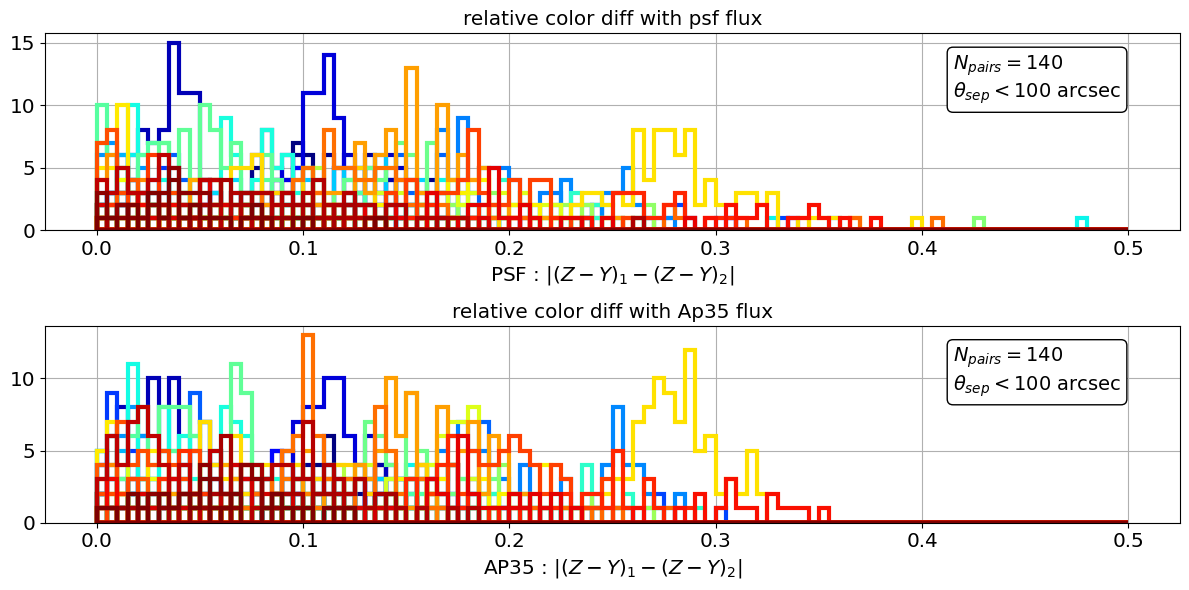

In [34]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
all_objectplotcolor = [] # compute median color per object
all_Ntimepoints = []
for idx,df in enumerate(all_colors_diff):
    df["psfcol12_s12"].hist(bins=100,range=(0,0.5),ax=ax1,histtype="step",color=colors_forplots[idx],lw=3)
ax1.set_title("relative color diff with psf flux")
ax1.text(0.8, 0.9, textstr, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)

for idx,df in enumerate(all_colors_diff):
    df["apcol12_s12"].hist(bins=100,range=(0,0.5),ax=ax2,histtype="step",color=colors_forplots[idx],lw=3)
    data =  df["apcol12_s12"].values
    if len(data)>=1:
        data= data[np.isfinite(data)]
        all_objectplotcolor.append(np.median(data))
        all_Ntimepoints.append(len(data))
    else:
        all_objectplotcolor.append(0.)
        
ax1.set_xlabel("PSF : $|(Z-Y)_1 - (Z-Y)_2|$")
ax2.set_xlabel("AP35 : $|(Z-Y)_1 - (Z-Y)_2|$")

ax2.set_title("relative color diff with Ap35 flux")
ax2.text(0.8, 0.9, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.tight_layout()

## Plots

In [35]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=0.35)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(all_objectplotcolor, alpha=1)


https://matplotlib.org/stable/users/explain/colors/colorbar_only.html

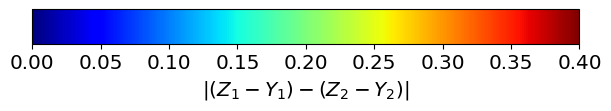

In [36]:
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal', label='$|(Z_1-Y_1)-(Z_2-Y_2)|$')


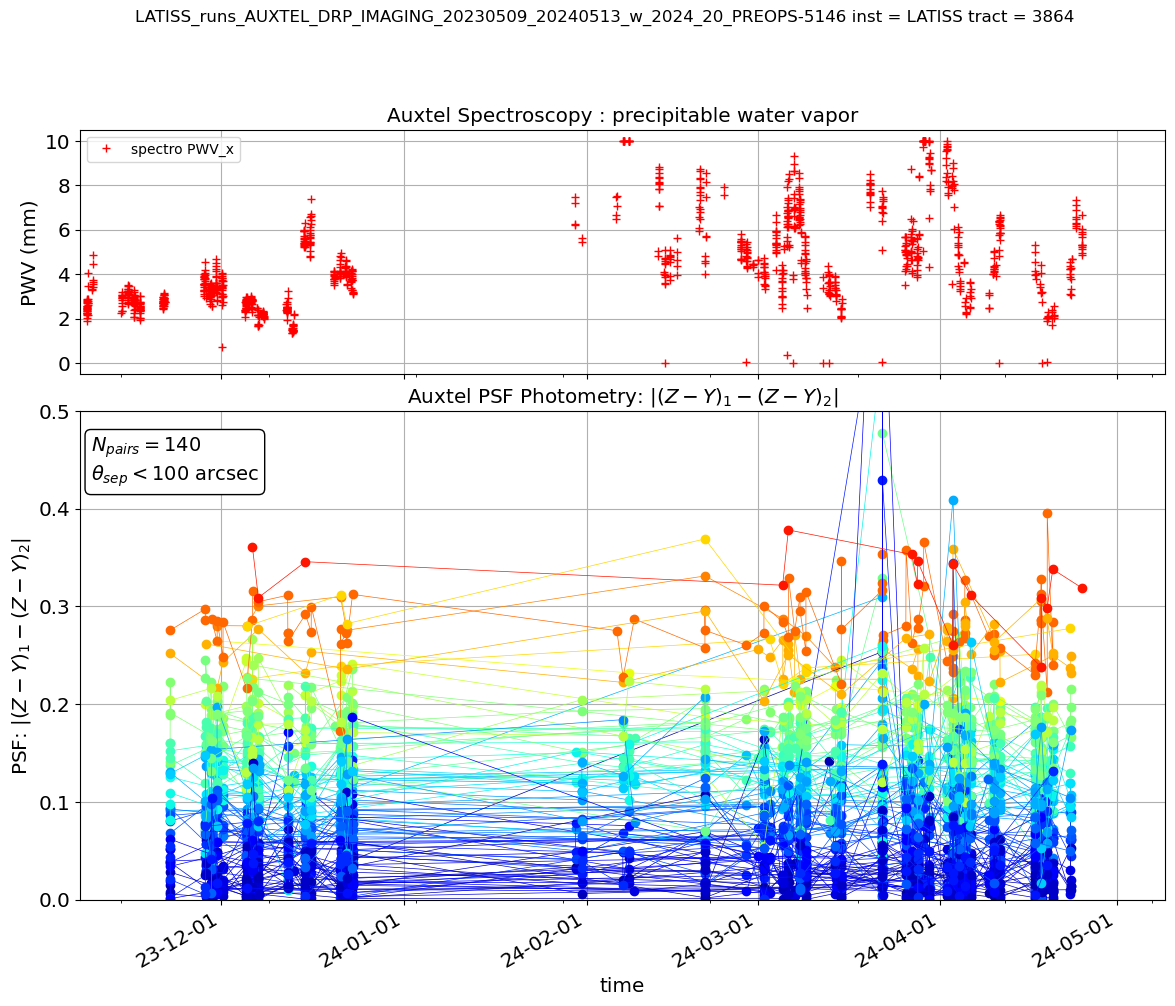

In [37]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(2, 1, wspace=0, hspace=0.1, height_ratios=[1,2],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)


df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    if(len(df_col)>5):

        #print(idx,df_col)
        df_col.plot(x="time1",y="psfcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
        #ax2.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,ecolor="k",fmt="o")

        tmin = df_col["time1"].min()
        tmax = df_col["time1"].max()
        
        dt = tmax-tmin
        tmin = tmin-dt/10
        tmax = tmax+dt/10
        all_tmin.append(tmin)
        all_tmax.append(tmax)

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax2.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel PSF Photometry: $|(Z-Y)_1-(Z-Y)_2|$")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("PSF: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.set_ylim(0.,0.5)
ax2.text(0.01, 0.95, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)

title = suptitle
plt.suptitle(title,y=1)
plt.tight_layout()

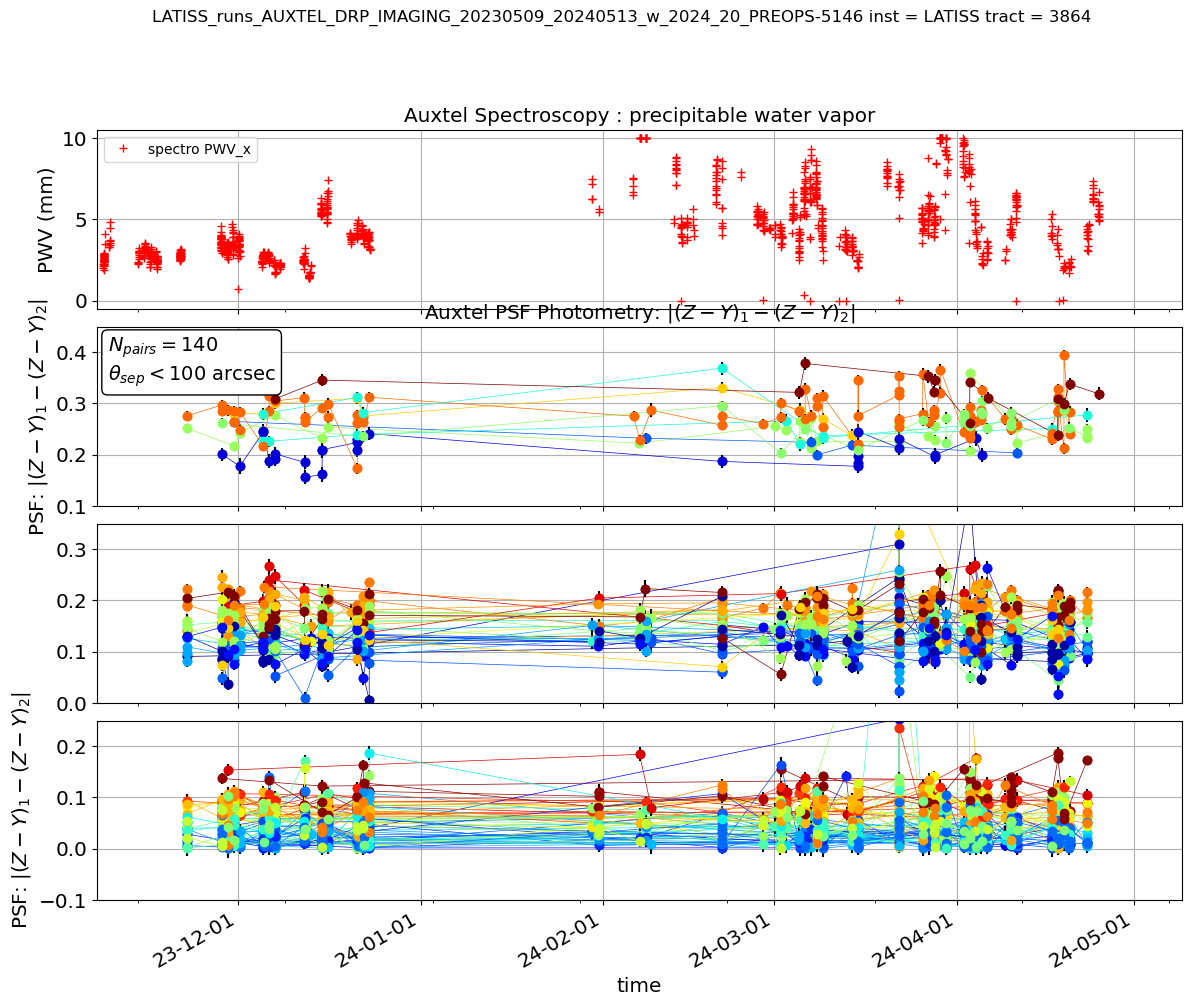

In [38]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(4, 1, wspace=0, hspace=0.1, height_ratios=[1,1,1,1],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)
ax3 = fig.add_subplot(gs[2],sharex=ax1)
ax4 = fig.add_subplot(gs[3],sharex=ax1)

## ax1
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

## ax2 ##

#Colormap
DCOLMIN = 0.2
DCOLMAX = 0.3
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=DCOLMIN, vmax=DCOLMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for idx,df_col in enumerate(all_colors_diff):
    if(len(df_col)>5):
        the_relativecolor = all_objectplotcolor[idx] 
        if the_relativecolor> DCOLMIN :
            the_color = scalarMap.to_rgba(the_relativecolor, alpha=1)
            df_col.plot(x="time1",y="psfcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
            ax2.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,ecolor="k",fmt="o")

            tmin = df_col["time1"].min()
            tmax = df_col["time1"].max()
            dt = tmax-tmin
            tmin = tmin-dt/10
            tmax = tmax+dt/10
            all_tmin.append(tmin)
            all_tmax.append(tmax)

ax2.set_ylim(DCOLMIN-0.1,DCOLMAX+0.15)

## ax3

#Colormap
DCOLMIN = 0.1
DCOLMAX = 0.2
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=DCOLMIN, vmax=DCOLMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for idx,df_col in enumerate(all_colors_diff):
    if(len(df_col)>5):
        the_relativecolor = all_objectplotcolor[idx] 
        if the_relativecolor> DCOLMIN  and  the_relativecolor<= DCOLMAX:
            the_color = scalarMap.to_rgba(the_relativecolor, alpha=1)
            df_col.plot(x="time1",y="psfcol12_s12",ax=ax3,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
            ax3.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,ecolor="k",fmt="o")

            tmin = df_col["time1"].min()
            tmax = df_col["time1"].max()
            dt = tmax-tmin
            tmin = tmin-dt/10
            tmax = tmax+dt/10
            all_tmin.append(tmin)
            all_tmax.append(tmax)

ax3.set_ylim(DCOLMIN-0.1,DCOLMAX+0.15)
## ax4

#Colormap
DCOLMIN = 0.
DCOLMAX = 0.1
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=DCOLMIN, vmax=DCOLMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for idx,df_col in enumerate(all_colors_diff):
    if(len(df_col)>5):
        the_relativecolor = all_objectplotcolor[idx] 
        if the_relativecolor> DCOLMIN  and  the_relativecolor<= DCOLMAX:
            the_color = scalarMap.to_rgba(the_relativecolor, alpha=1)
            df_col.plot(x="time1",y="psfcol12_s12",ax=ax4,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
            ax4.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,ecolor="k",fmt="o")

            tmin = df_col["time1"].min()
            tmax = df_col["time1"].max()
            dt = tmax-tmin
            tmin = tmin-dt/10
            tmax = tmax+dt/10
            all_tmin.append(tmin)
            all_tmax.append(tmax)

ax4.set_ylim(DCOLMIN-0.1,DCOLMAX+0.15)

ax4.set_xlabel("time")
ax4.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax4.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel PSF Photometry: $|(Z-Y)_1-(Z-Y)_2|$")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("PSF: $|(Z-Y)_1-(Z-Y)_2|$")
ax4.set_ylabel("PSF: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.text(0.01, 0.95, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)


title = suptitle
plt.suptitle(title,y=1.)
plt.tight_layout()

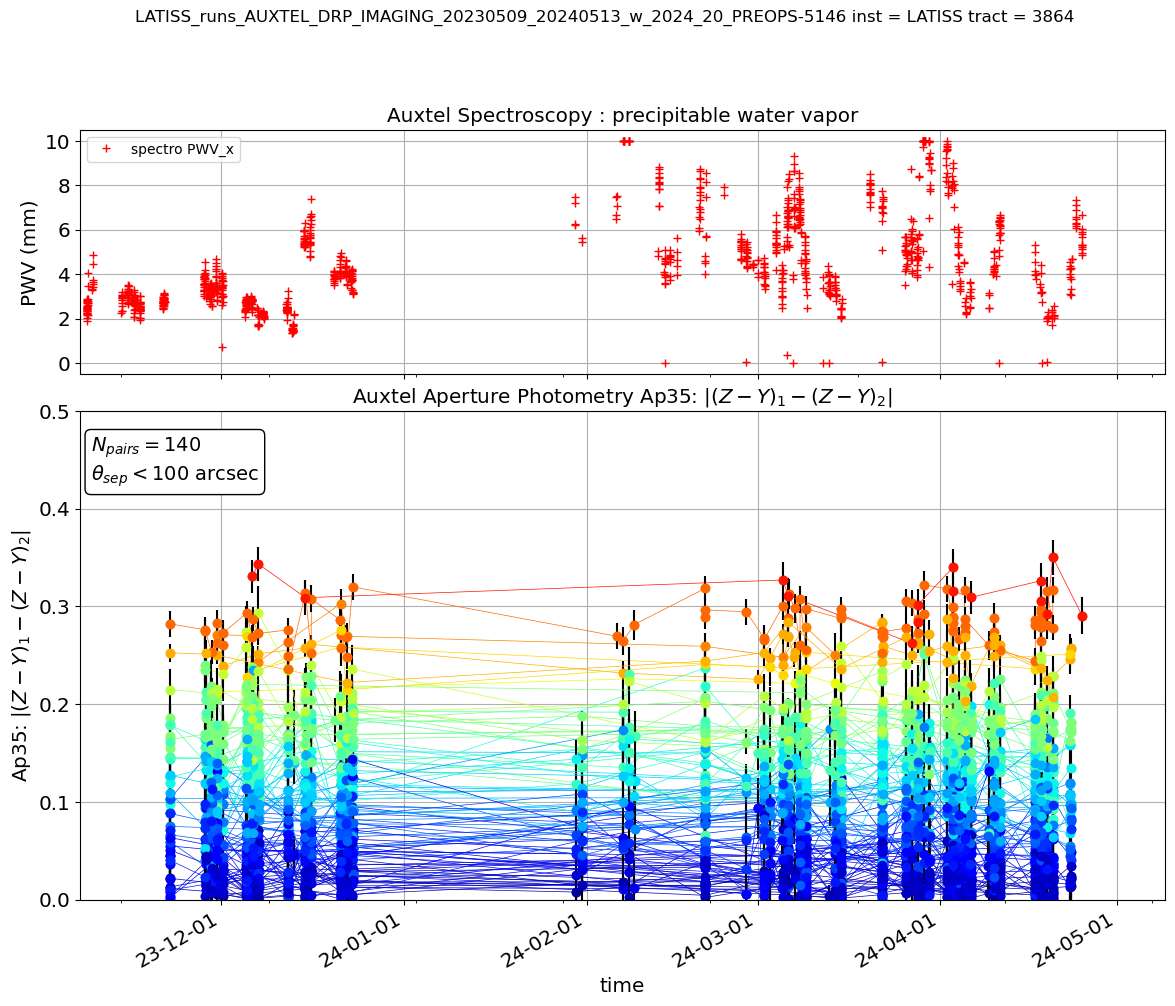

In [39]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(2, 1, wspace=0, hspace=0.1, height_ratios=[1,2],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)


df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    if(len(df_col)>5):
        df_col.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
        ax2.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

        tmin = df_col["time1"].min()
        tmax = df_col["time1"].max()
        dt = tmax-tmin
        tmin = tmin-dt/10
        tmax = tmax+dt/10
        all_tmin.append(tmin)
        all_tmax.append(tmax)

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax2.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel Aperture Photometry Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.set_ylim(0.,0.5)
ax2.text(0.01, 0.95, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)

title = suptitle
plt.suptitle(title,y=1.)
plt.tight_layout()

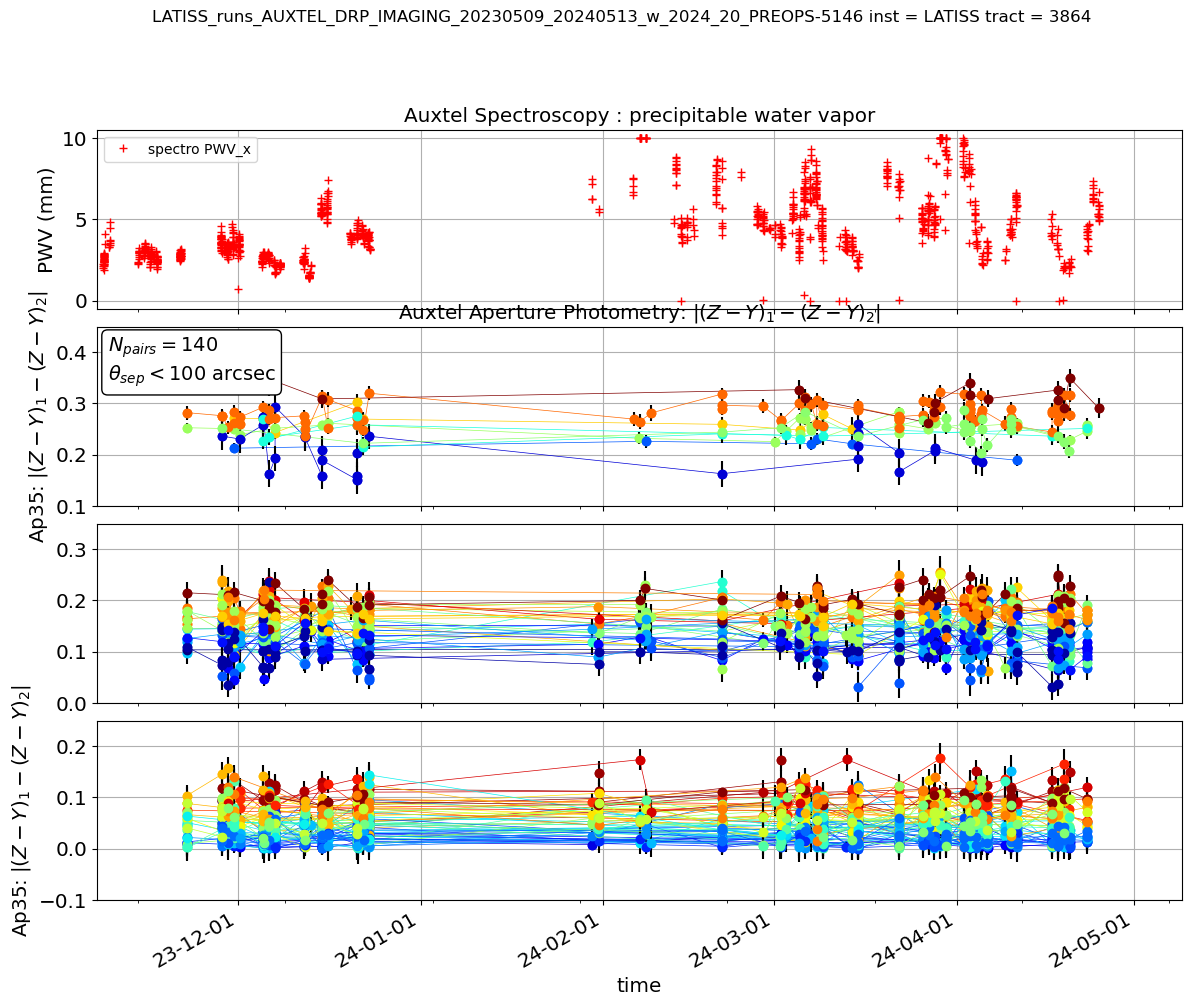

In [40]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(4, 1, wspace=0, hspace=0.1, height_ratios=[1,1,1,1],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)
ax3 = fig.add_subplot(gs[2],sharex=ax1)
ax4 = fig.add_subplot(gs[3],sharex=ax1)

## ax1
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

## ax2 ##

#Colormap
DCOLMIN = 0.2
DCOLMAX = 0.3
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=DCOLMIN, vmax=DCOLMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for idx,df_col in enumerate(all_colors_diff):
    if(len(df_col)>5):
        the_relativecolor = all_objectplotcolor[idx] 
        if the_relativecolor> DCOLMIN :
            the_color = scalarMap.to_rgba(the_relativecolor, alpha=1)
            df_col.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
            ax2.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

            tmin = df_col["time1"].min()
            tmax = df_col["time1"].max()
            dt = tmax-tmin
            tmin = tmin-dt/10
            tmax = tmax+dt/10
            all_tmin.append(tmin)
            all_tmax.append(tmax)

ax2.set_ylim(DCOLMIN-0.1,DCOLMAX+0.15)

## ax3

#Colormap
DCOLMIN = 0.1
DCOLMAX = 0.2
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=DCOLMIN, vmax=DCOLMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for idx,df_col in enumerate(all_colors_diff):
    if(len(df_col)>5):
        the_relativecolor = all_objectplotcolor[idx] 
        if the_relativecolor> DCOLMIN  and  the_relativecolor<= DCOLMAX:
            the_color = scalarMap.to_rgba(the_relativecolor, alpha=1)
            df_col.plot(x="time1",y="apcol12_s12",ax=ax3,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
            ax3.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

            tmin = df_col["time1"].min()
            tmax = df_col["time1"].max()
            dt = tmax-tmin
            tmin = tmin-dt/10
            tmax = tmax+dt/10
            all_tmin.append(tmin)
            all_tmax.append(tmax)

ax3.set_ylim(DCOLMIN-0.1,DCOLMAX+0.15)
## ax4

#Colormap
DCOLMIN = 0.
DCOLMAX = 0.1
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=DCOLMIN, vmax=DCOLMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for idx,df_col in enumerate(all_colors_diff):
    if(len(df_col)>5):
        the_relativecolor = all_objectplotcolor[idx] 
        if the_relativecolor> DCOLMIN  and  the_relativecolor<= DCOLMAX:
            the_color = scalarMap.to_rgba(the_relativecolor, alpha=1)
            df_col.plot(x="time1",y="apcol12_s12",ax=ax4,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
            ax4.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

            tmin = df_col["time1"].min()
            tmax = df_col["time1"].max()
            dt = tmax-tmin
            tmin = tmin-dt/10
            tmax = tmax+dt/10
            all_tmin.append(tmin)
            all_tmax.append(tmax)

ax4.set_ylim(DCOLMIN-0.1,DCOLMAX+0.15)

ax4.set_xlabel("time")
ax4.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax4.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel Aperture Photometry: $|(Z-Y)_1-(Z-Y)_2|$")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax4.set_ylabel("Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.text(0.01, 0.95, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)


title = suptitle
plt.suptitle(title,y=1.)
plt.tight_layout()

## Choose 2 Light curves

- pairs in sample $\theta_{sep} $ < 100 arcsec

In [41]:
#idx_pair1 = 7
idx_pair1= 38
#
idx_pair2 = 93
#idx_pair2 = 36
#idx_pair2= 95

idx_pair3= 110


In [42]:
df_pair1 = df_summary[df_summary.idx_pair == idx_pair1]
df_pair2 = df_summary[df_summary.idx_pair == idx_pair2]
df_pair3 = df_summary[df_summary.idx_pair == idx_pair3]

In [43]:
df_pair1

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
38      38.0     346.0     392.0  48.0       0.018652          33.0   

    refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  \
38      0.016139         33.0  0.015738    0.00952   33.0  13.774577   

    drefcol_psf_ap  
38        0.002513

In [44]:
df_pair2

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
92      93.0      97.0     262.0  80.0       0.275624          88.0   

    refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  \
92      0.279843         88.0  0.281531   0.019038   88.0  14.213496   

    drefcol_psf_ap  
92       -0.004219

In [45]:
textstr1 = '\n'.join((
    "small (Y-Z) diff pair :"
    r'objects =(%.0f,%.0f)' % (df_pair1["idx_obj1"],df_pair1["idx_obj2"],  ),
    r'$\theta_{sep} = %.0f$ arcsec' % (df_pair1["sep"], ),
    r'$|(Y-Z)_1- (Y-Z)_2| \simeq%.3f$  mag' % (df_pair1["refcol_ap_md"], )))
textstr2 = '\n'.join((
    "large (Y-Z) diff pair : "
    r'objects =(%.0f,%.0f)' % (df_pair2["idx_obj1"],df_pair2["idx_obj2"],  ),
    r'$\theta_{sep} = %.0f$ arcsec' % (df_pair2["sep"], ),
    r'$|(Y-Z)_1- (Y-Z)_2| \simeq%.3f$  mag' % (df_pair2["refcol_ap_md"], )))

textstr3 = '\n'.join((
    "large (Y-Z) diff pair : "
    r'objects =(%.0f,%.0f)' % (df_pair3["idx_obj1"],df_pair3["idx_obj2"],  ),
    r'$\theta_{sep} = %.0f$ arcsec' % (df_pair3["sep"], ),
    r'$|(Y-Z)_1- (Y-Z)_2| \simeq%.3f$  mag' % (df_pair3["refcol_ap_md"], )))

### Save selected pairs to study in plots

In [46]:
for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    if (idx == idx_pair1) or (idx == idx_pair2) or (idx == idx_pair3):
        the_df_pair = df_summary[df_summary.idx_pair == idx]
        obj1 = the_df_pair["idx_obj1"].values[0]
        obj2 = the_df_pair["idx_obj2"].values[0]
        pair_filename = f"pair_num_{idx}-o{obj1:.0f}-o{obj2:.0f}-colZ-Y.csv"
        df_col.to_csv(pair_filename)

In [47]:
#df_col

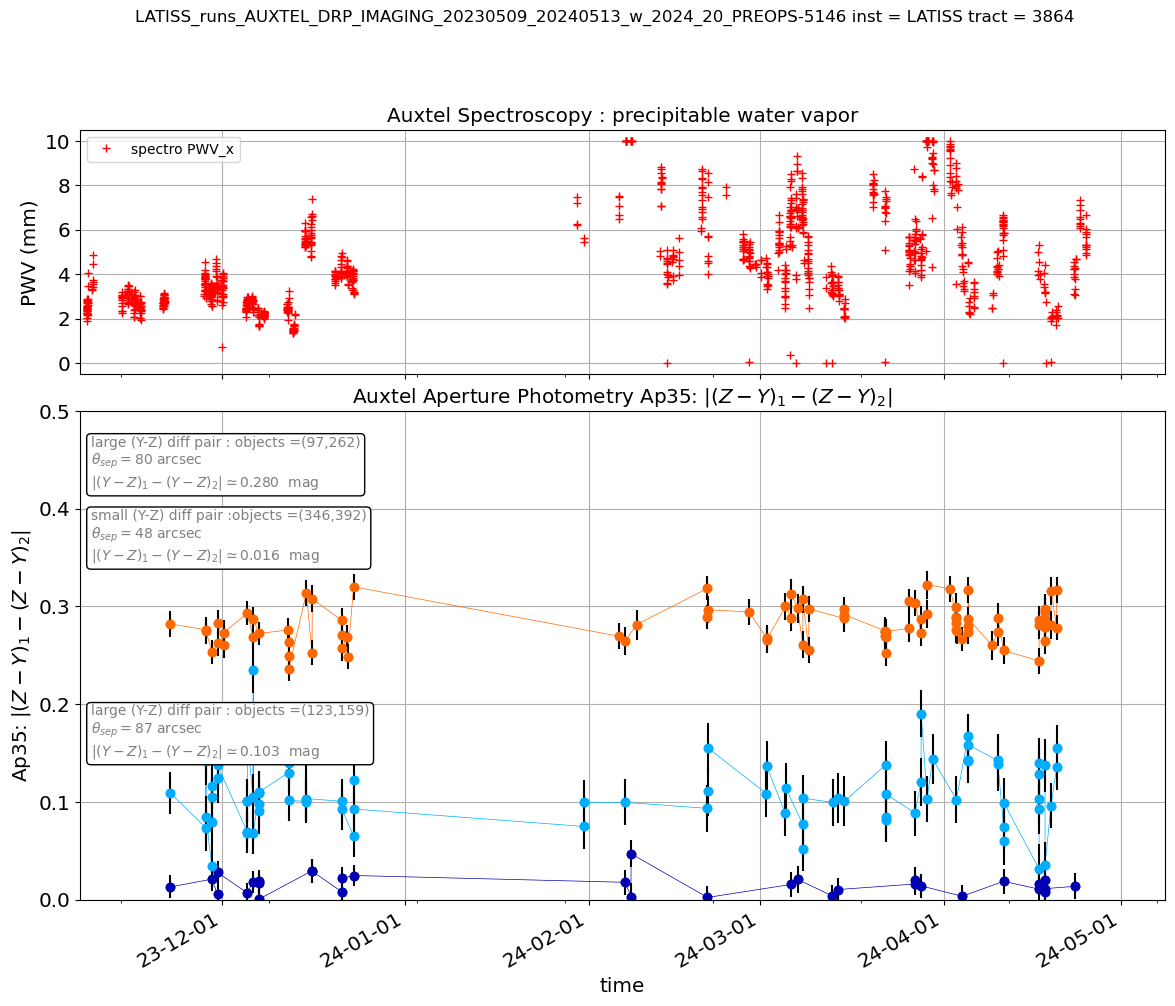

In [48]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(2, 1, wspace=0, hspace=0.1, height_ratios=[1,2],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)


df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    idx_thispair = df_col 	

    if (idx == idx_pair1) or (idx == idx_pair2) or (idx == idx_pair3):

        # psf
        #df_col.plot(x="time1",y="psfcol12_s12",ax=ax2,marker="o",color=the_color,fillstyle='none',lw=0.5,grid=True,legend=False)
        #ax2.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,fillstyle='none',ecolor="grey",fmt="o")

        # aperture
        df_col.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
        ax2.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

        tmin = df_col["time1"].min()
        tmax = df_col["time1"].max()
        dt = tmax-tmin
        tmin = tmin-dt/10
        tmax = tmax+dt/10
        all_tmin.append(tmin)
        all_tmax.append(tmax)

#    if (idx == idx_pair1) :
#        print(df_col)

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax2.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel Aperture Photometry Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.set_ylim(0.,0.5)
ax2.text(0.01, 0.95, textstr2, transform=ax2.transAxes, fontsize=10,verticalalignment='top', bbox=props,alpha=0.5)
ax2.text(0.01, 0.8, textstr1, transform=ax2.transAxes, fontsize=10,verticalalignment='top', bbox=props,alpha=0.5)
ax2.text(0.01, 0.4, textstr3, transform=ax2.transAxes, fontsize=10,verticalalignment='top', bbox=props,alpha=0.5)

title = suptitle
plt.suptitle(title,y=1.)
plt.tight_layout()

Text(0.5, 1.0, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146 inst = LATISS tract = 3864')

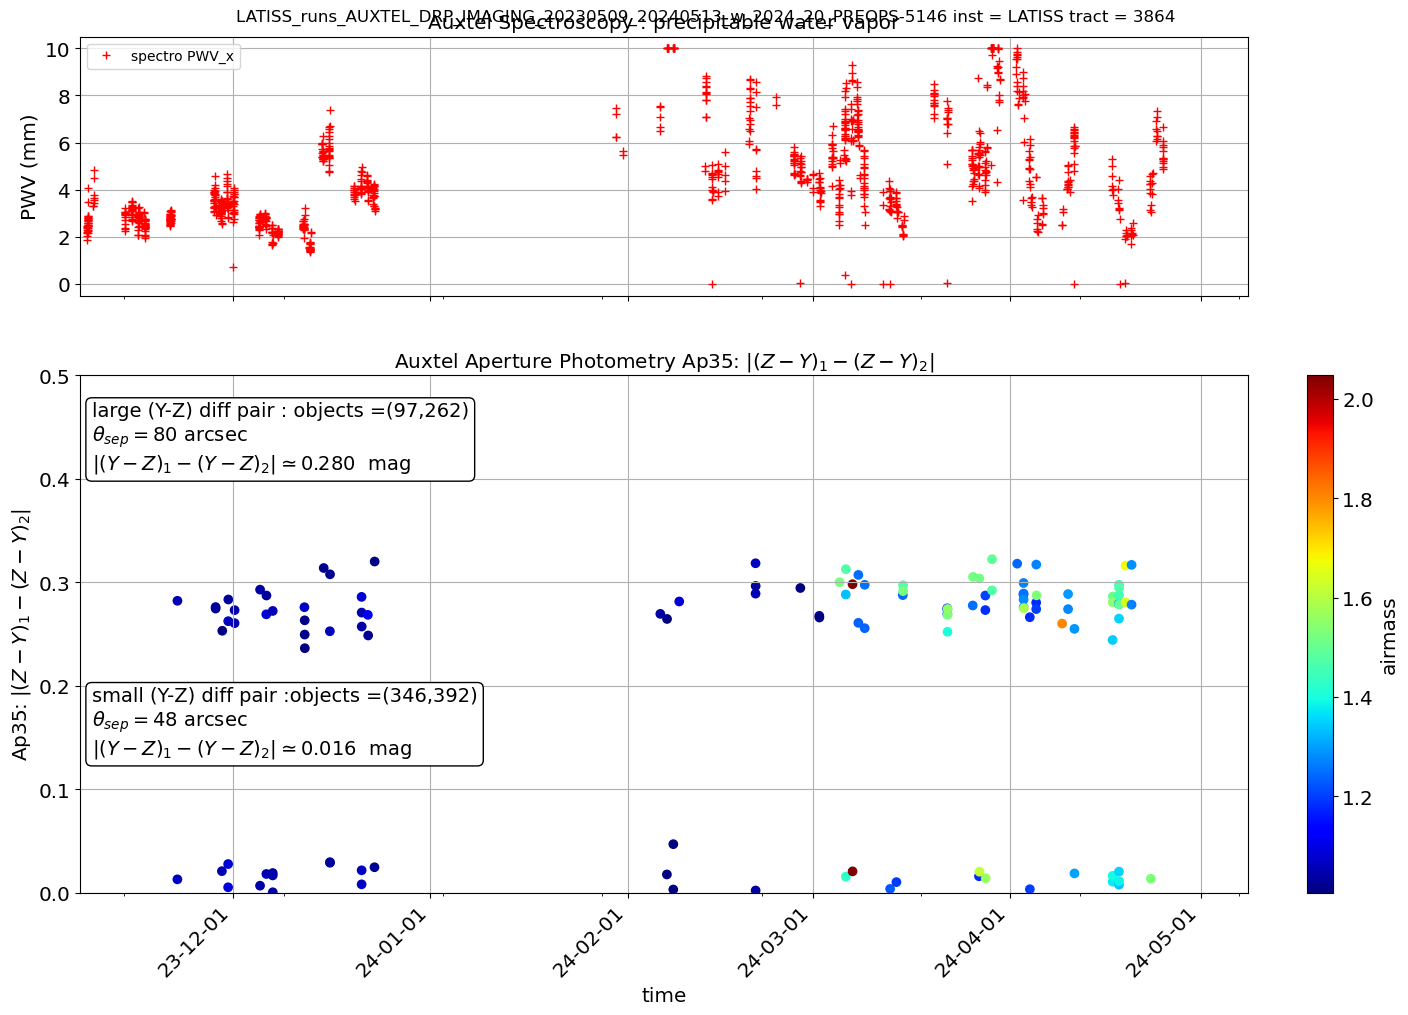

In [49]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(2, 1, wspace=0, hspace=0.1, height_ratios=[1,2],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)


df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    if (idx == idx_pair1) or (idx == idx_pair2):

        # psf
        #df_col.plot(x="time1",y="psfcol12_s12",ax=ax2,marker="o",color=the_color,fillstyle='none',lw=0.5,grid=True,legend=False)
        #ax2.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,fillstyle='none',ecolor="grey",fmt="o")

        # aperture
        #df_col.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
        #ax2.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,ecolor="k",fmt=".",facecolor=None)
        #df_col.plot.scatter(x="time1",y="apcol12_s12",ax=ax2,c=df_col.airmassb1,cmap="jet",grid=True,legend=False)
        #df_col.plot.scatter(x="time1",y="apcol12_s12",ax=ax2,s=30,color=df_col.airmassb1,cmap="jet")
        sc2 = ax2.scatter(df_col.time1,df_col.apcol12_s12,c=df_col.airmassb1,cmap="jet")

        tmin = df_col["time1"].min()
        tmax = df_col["time1"].max()
        dt = tmax-tmin
        tmin = tmin-dt/10
        tmax = tmax+dt/10
        all_tmin.append(tmin)
        all_tmax.append(tmax)

ax2.set_xlabel("time")
ax2.grid()
ax2.xaxis.set_major_formatter(date_form)

#cbar2 = plt.colorbar(ax2.collections[0],ax=ax2)
cbar=plt.colorbar(sc2)
cbar.set_label("airmass", rotation=90)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax2.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel Aperture Photometry Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim(0.,0.5)
ax2.text(0.01, 0.95, textstr2, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.text(0.01, 0.4, textstr1, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)

title = suptitle
plt.suptitle(title,y=1.)
#plt.tight_layout()

## Check if spread varies with (Z-Y) relative difference

In [50]:
#df_summary

In [51]:
for index in range(len(df_summary["idx_pair"])):
    #print(df_summary.iloc[index][["idx_pair","idx_obj1","idx_obj2"]])
    text = "{:}){:}({:},{:})".format(index, int(df_summary.iloc[index]["idx_pair"]), int(df_summary.iloc[index]["idx_obj1"]),int(df_summary.iloc[index]["idx_obj2"]))
    #print(text)

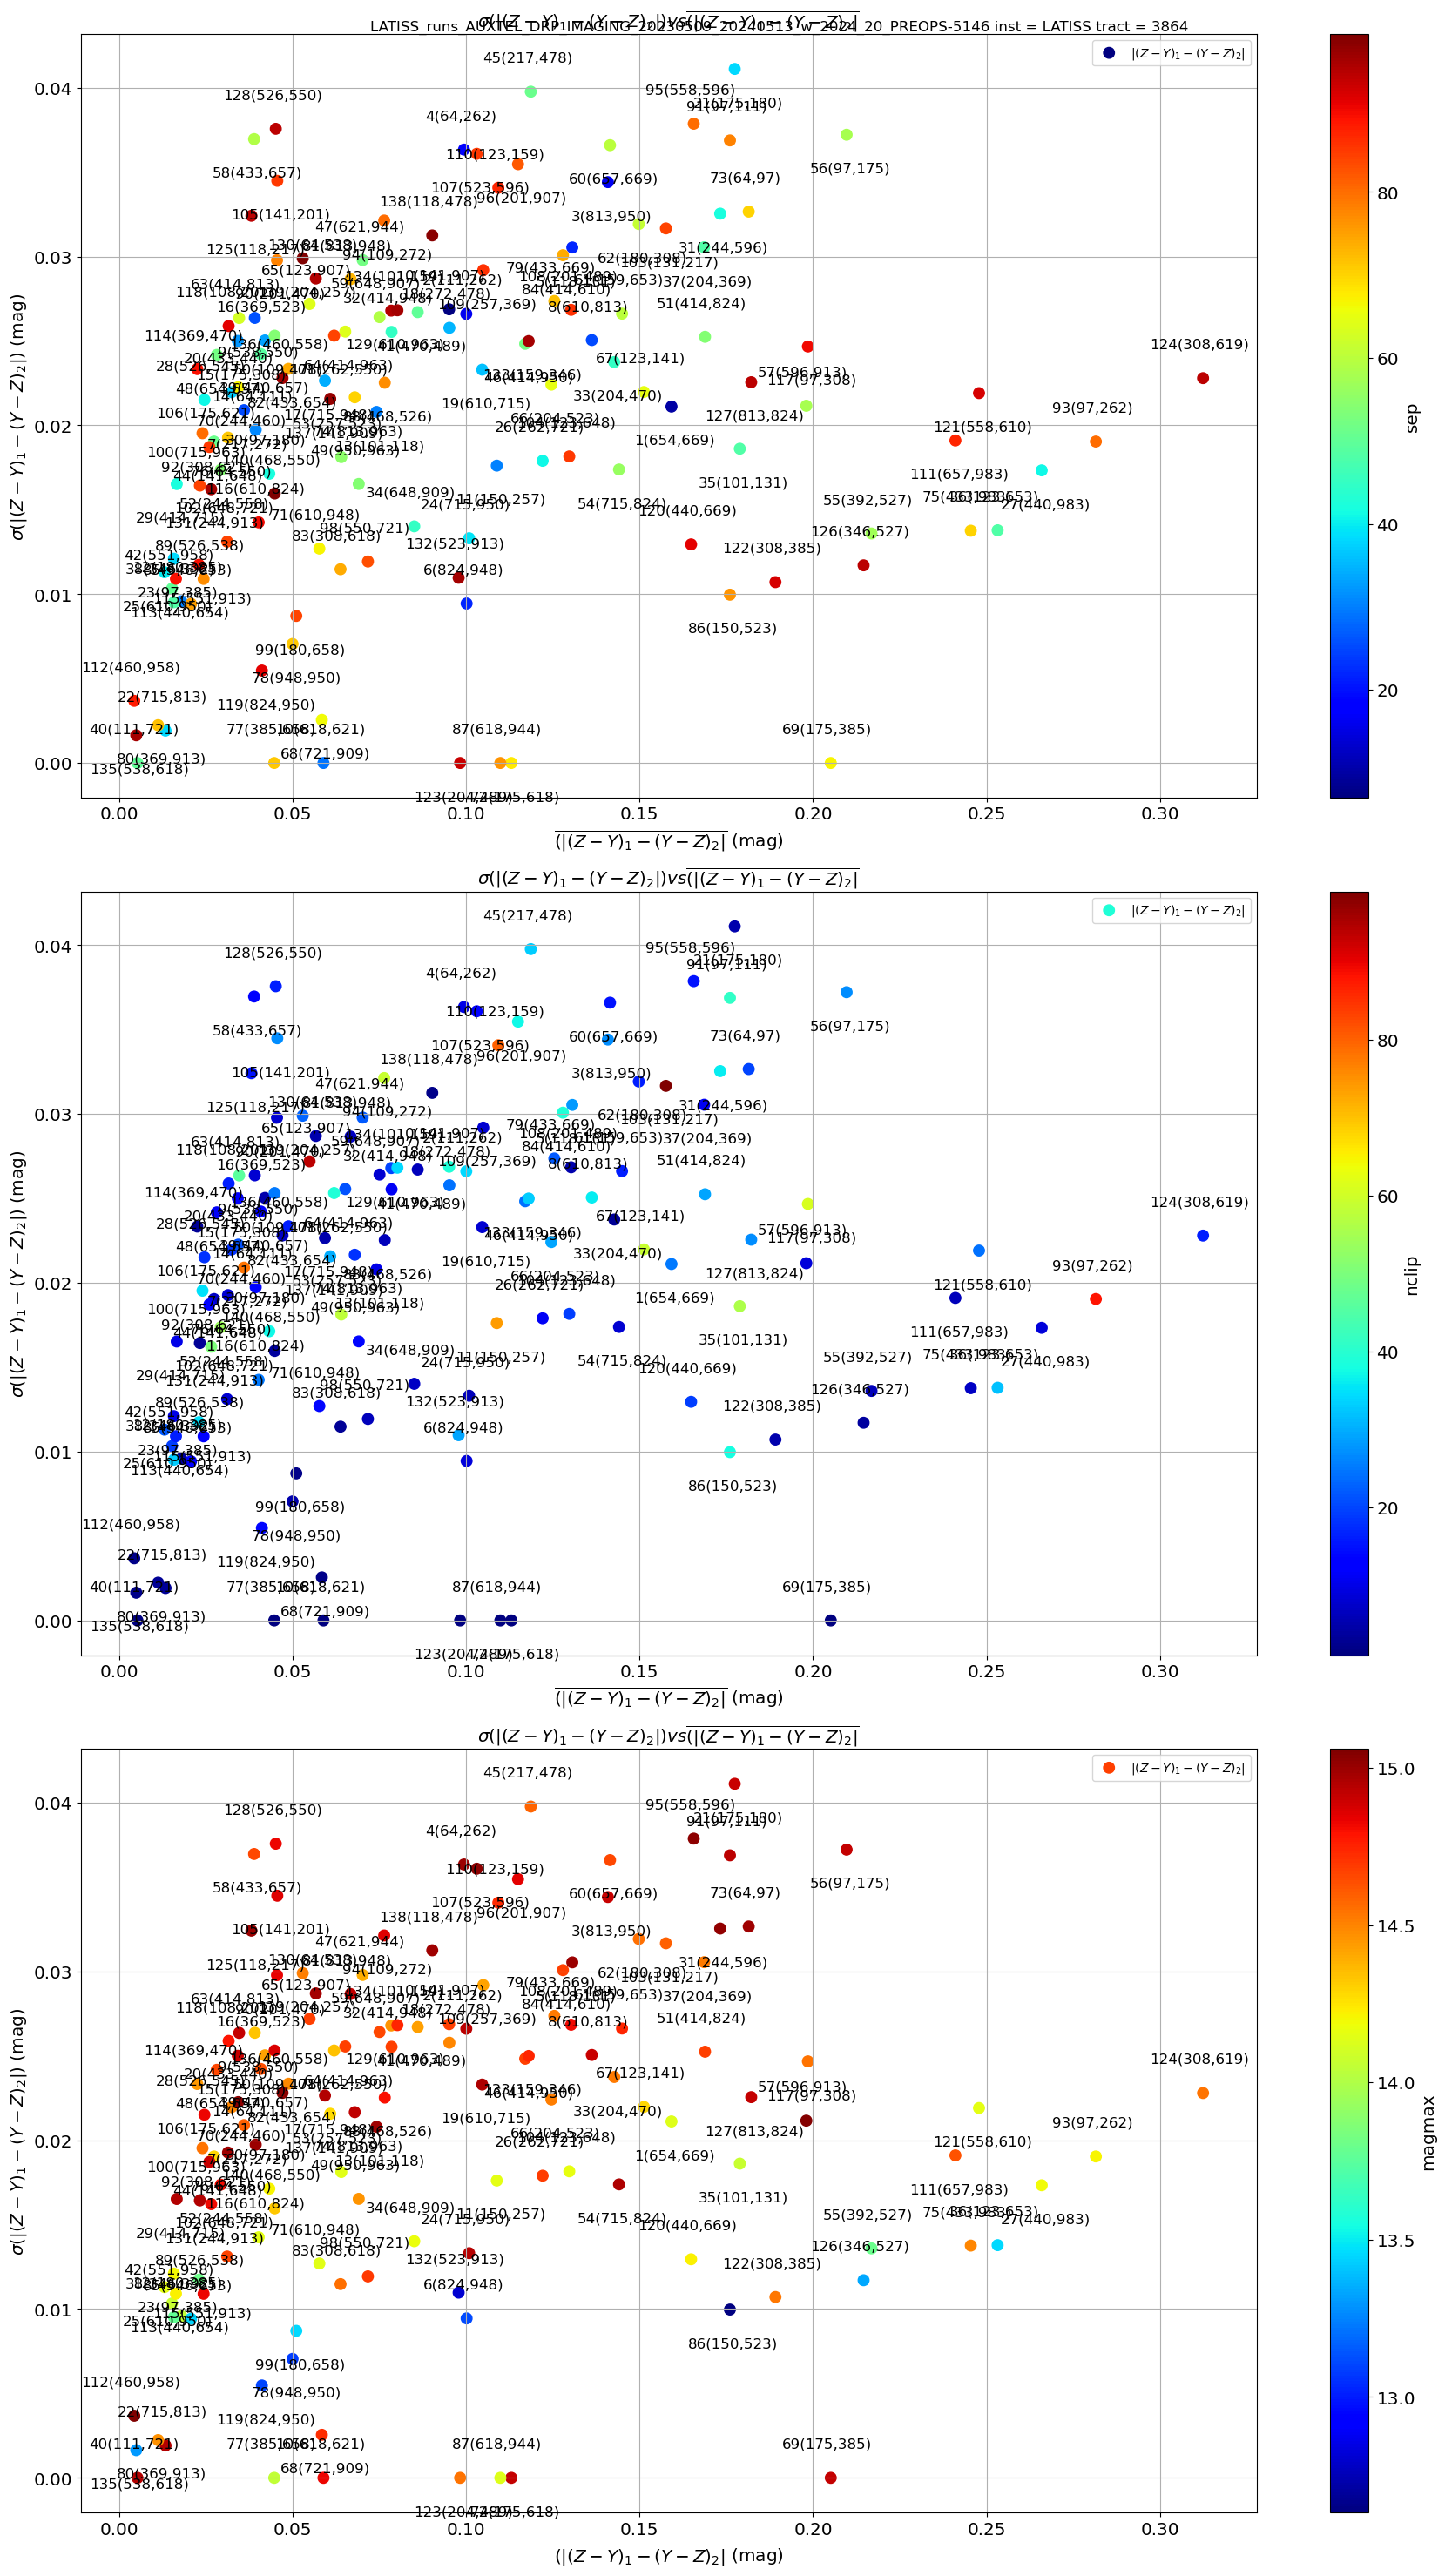

In [52]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(18,30))
title = f"AuxtelLightCurves"


sc1=df_summary.plot.scatter(x= "muclip",y="sigmaclip",ax=ax1,s=80, c= "sep",cmap="jet", label="$|(Z-Y)_1 - (Y-Z)_2|$", grid=True,colorbar=True)
sc2=df_summary.plot.scatter(x= "muclip",y="sigmaclip",ax=ax2,s=80, c= "nclip",cmap="jet", label="$|(Z-Y)_1 - (Y-Z)_2|$", grid=True,colorbar=True)
sc3=df_summary.plot.scatter(x= "muclip",y="sigmaclip",ax=ax3,s=80, c= "magmax",cmap="jet", label="$|(Z-Y)_1 - (Y-Z)_2|$", grid=True,colorbar=True)

ax1.set_title(title)
ax1.set_title("$\\sigma (|(Z-Y)_1 - (Y-Z)_2|) vs \overline{(|(Z-Y)_1 - (Y-Z)_2|}$")
ax1.set_xlabel("$\overline{(|(Z-Y)_1 - (Y-Z)_2|}$ (mag)")
ax1.set_ylabel("$\\sigma (|(Z-Y)_1 - (Y-Z)_2|) $ (mag)")



ax2.set_title("$\\sigma (|(Z-Y)_1 - (Y-Z)_2|) vs \overline{(|(Z-Y)_1 - (Y-Z)_2|}$")
ax2.set_xlabel("$\overline{(|(Z-Y)_1 - (Y-Z)_2|}$ (mag)")
ax2.set_ylabel("$\\sigma (|(Z-Y)_1 - (Y-Z)_2|) $ (mag)")


ax3.set_title("$\\sigma (|(Z-Y)_1 - (Y-Z)_2|) vs \overline{(|(Z-Y)_1 - (Y-Z)_2|}$")
ax3.set_xlabel("$\overline{(|(Z-Y)_1 - (Y-Z)_2|}$ (mag)")
ax3.set_ylabel("$\\sigma (|(Z-Y)_1 - (Y-Z)_2|) $ (mag)")

#cbar1 = plt.colorbar(ax1.collections[0],ax=ax1,orientation = 'horizontal',shrink=0.6)
#cbar1 = plt.colorbar(ax1.collections[0],ax=ax1,orientation = 'horizontal',shrink=0.6)
#cbar1.ax.set_xlabel('angular separation (arcsec)',rotation=0)

#cbar2 = plt.colorbar(ax2.collections[0],ax=ax2,orientation = 'horizontal',shrink=0.6)
#cbar2.ax.set_xlabel('number of points',rotation=0)

for index in range(len(df_summary["idx_pair"])):
    #print(df_summary.iloc[index][["idx_pair","idx_obj1","idx_obj2"]])
    text = "{:}({:},{:})".format( int(df_summary.iloc[index]["idx_pair"]), int(df_summary.iloc[index]["idx_obj1"]),int(df_summary.iloc[index]["idx_obj2"]))

    x = df_summary.iloc[index]["muclip"]
    y = df_summary.iloc[index]["sigmaclip"]
    
    if index%2 == 0:
        ax1.text(x-0.001,y+.002,text,size= 'large',horizontalalignment='center',verticalalignment='center')
        ax2.text(x-0.001,y+.002,text,size= 'large',horizontalalignment='center',verticalalignment='center')
        ax3.text(x-0.001,y+.002,text,size= 'large',horizontalalignment='center',verticalalignment='center')
    else:
        ax1.text(x+0.001,y-0.002,text,size= 'large',horizontalalignment='center',verticalalignment='center')
        ax2.text(x+0.001,y-0.002,text,size= 'large',horizontalalignment='center',verticalalignment='center')
        ax3.text(x+0.001,y-0.002,text,size= 'large',horizontalalignment='center',verticalalignment='center')

plt.suptitle(suptitle)
plt.tight_layout()
plt.show()


Text(0, 0.5, '$\\sigma(|(Z-Y)_1 - (Z-Y)_2|$ (mag)')

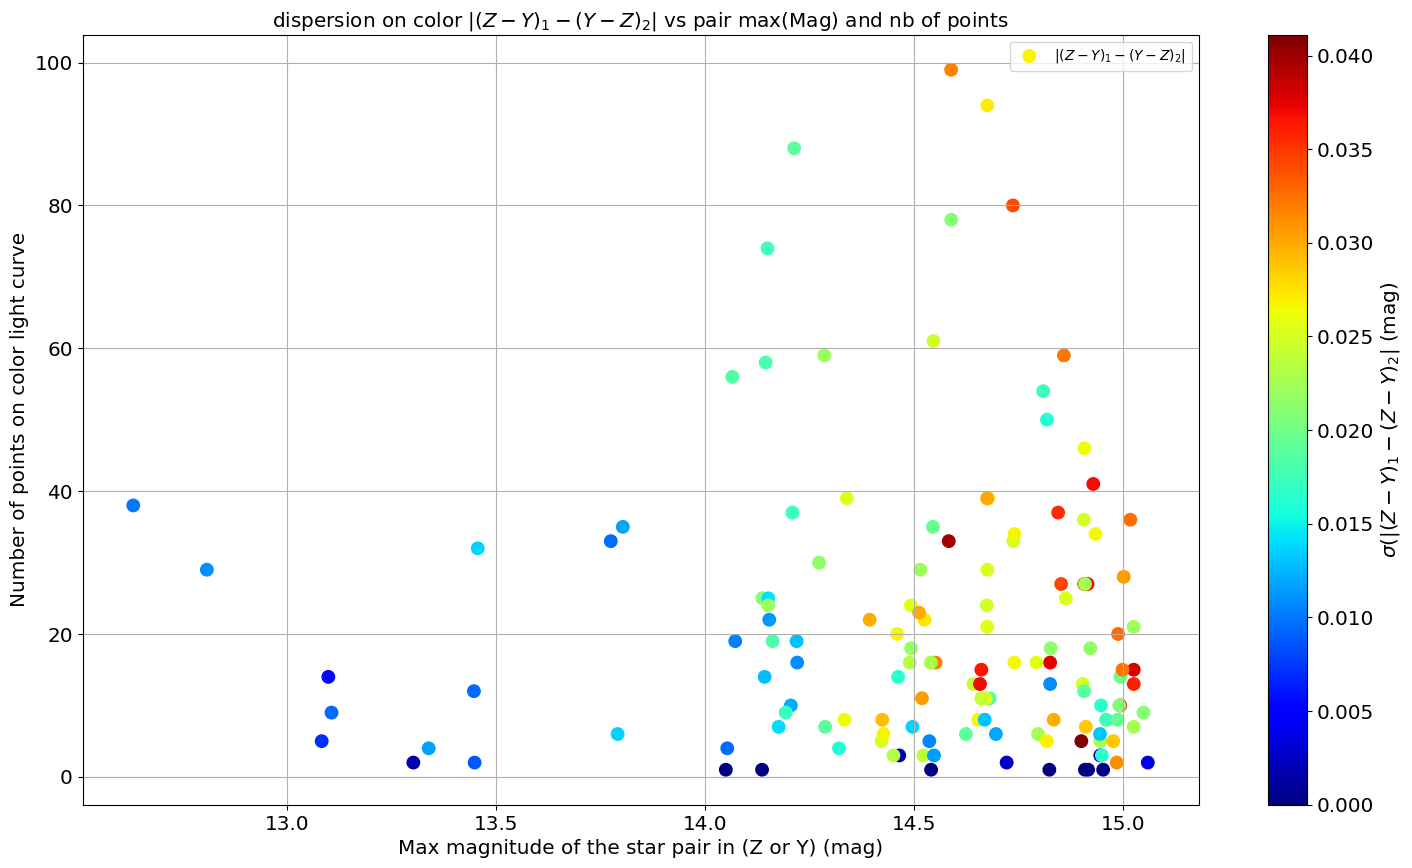

In [53]:
fig, ax1 = plt.subplots(1,1,figsize=(18,10))
title = f"AuxtelLightCurves"


sc1=df_summary.plot.scatter(x= "magmax",y="nclip",ax=ax1,s=80, c= "sigmaclip",cmap="jet", label="$|(Z-Y)_1 - (Y-Z)_2|$", grid=True,colorbar=True)
ax1.set_title("dispersion on color $|(Z-Y)_1 - (Y-Z)_2|$ vs pair max(Mag) and nb of points")
ax1.set_xlabel("Max magnitude of the star pair in (Z or Y) (mag)")
ax1.set_ylabel("Number of points on color light curve")


f = plt.gcf()
cax = f.get_axes()[1]
#and we can modify it, i.e.:
cax.set_ylabel('$\sigma(|(Z-Y)_1 - (Z-Y)_2|$ (mag)')

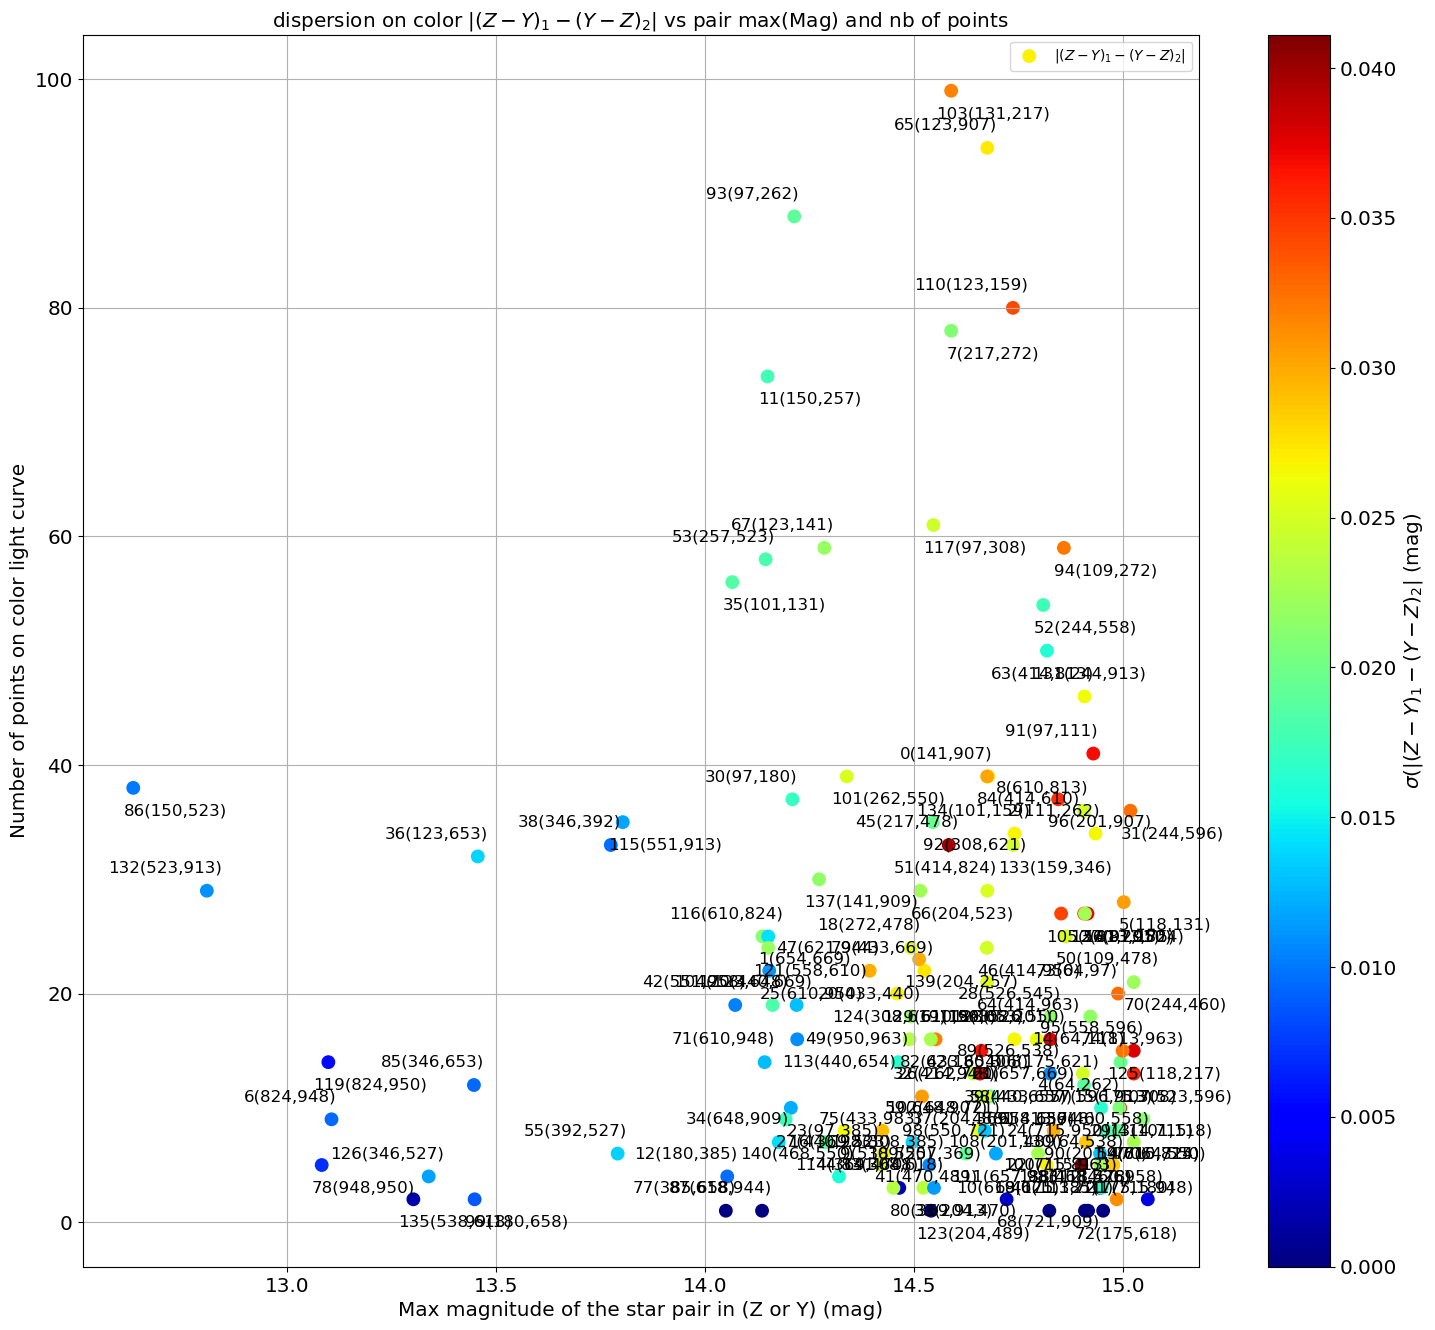

In [54]:
fig, ax1 = plt.subplots(1,1,figsize=(18,16))
title = f"AuxtelLightCurves"


sc1=df_summary.plot.scatter(x= "magmax",y="nclip",ax=ax1,s=80, c= "sigmaclip",cmap="jet", label="$|(Z-Y)_1 - (Y-Z)_2|$", grid=True,colorbar=True)
ax1.set_title("dispersion on color $|(Z-Y)_1 - (Y-Z)_2|$ vs pair max(Mag) and nb of points")
ax1.set_xlabel("Max magnitude of the star pair in (Z or Y) (mag)")
ax1.set_ylabel("Number of points on color light curve")


f = plt.gcf()
cax = f.get_axes()[1]
#and we can modify it, i.e.:
cax.set_ylabel('$\sigma(|(Z-Y)_1 - (Y-Z)_2|$ (mag)')
for index in range(len(df_summary["idx_pair"])):
    #print(df_summary.iloc[index][["idx_pair","idx_obj1","idx_obj2"]])
    text = "{:}({:},{:})".format( int(df_summary.iloc[index]["idx_pair"]), int(df_summary.iloc[index]["idx_obj1"]),int(df_summary.iloc[index]["idx_obj2"]))

    x = df_summary.iloc[index]["magmax"]
    y = df_summary.iloc[index]["nclip"]
    
    if index%2 == 0:
        ax1.text(x-0.1,y+2,text,size= 'large',horizontalalignment='center',verticalalignment='center')
    else:
        ax1.text(x+0.1,y-2,text,size= 'large',horizontalalignment='center',verticalalignment='center')

## Select good pairs

In [55]:
df_summary_sel = df_summary.assign(select = lambda row : (row["magmax"]<14.5) & (row["nclip"]>20) & (row["refcol_ap_md"]>0.1))

In [56]:
df_summary_sel.head()

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
0       0.0     141.0     907.0   7.0       0.089904          39.0   
1       1.0     654.0     669.0  10.0       0.157383          25.0   
2       2.0     111.0     262.0  16.0       0.094064          34.0   
3       3.0     813.0     950.0  16.0       0.134367          27.0   
4       4.0      64.0     262.0  18.0       0.073242          10.0   

   refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  \
0      0.095301         39.0  0.095078   0.026872   39.0  14.677654   
1      0.157931         25.0  0.159177   0.021111   25.0  14.137261   
2      0.097442         34.0  0.100023   0.026601   34.0  14.934727   
3      0.139636         27.0  0.140848   0.034404   27.0  14.907334   
4      0.093076         10.0  0.099348   0.036333   10.0  14.993679   

   drefcol_psf_ap  select  
0       -0.005396   False  
1       -0.000548    True  
2       -0.003378   False  
3       -0.005269   False  
4       -0.019834   False

In [57]:
good_indexes = df_summary_sel[df_summary_sel["select"]]["idx_pair"].values.astype(int)
good_indexes

array([  1,  11,  35,  36,  67,  86,  93, 121])

In [58]:
df_summary.loc[good_indexes]

idx_pair  idx_obj1  idx_obj2   sep  refcol_psf_md  n_refcol_psf  \
1         1.0     654.0     669.0  10.0       0.157383          25.0   
11       11.0     150.0     257.0  30.0       0.108866          74.0   
35       35.0     101.0     131.0  48.0       0.185609          56.0   
36       36.0     123.0     653.0  48.0       0.248857          32.0   
67       68.0     721.0     909.0  66.0       0.124073           2.0   
86       87.0     618.0     944.0  76.0       0.105934           1.0   
93       94.0     109.0     272.0  80.0       0.070569          59.0   
121     123.0     204.0     489.0  93.0       0.047220           1.0   

     refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  \
1        0.157931         25.0  0.159177   0.021111   25.0  14.137261   
11       0.111021         74.0  0.108814   0.017612   74.0  14.149658   
35       0.178427         56.0  0.178880   0.018614   56.0  14.065280   
36       0.253628         32.0  0.253206   0.013784   32.0  13.456232   
67       0.058382          2.0  0.058382   0.002552    2.0  14.721893   
86       0.109841          1.0  0.109841   0.000000    1.0  14.136590   
93       0.071283         59.0  0.076353   0.032130   59.0  14.858889   
121      0.098241          1.0  0.098241   0.000000    1.0  14.541118   

     drefcol_psf_ap  
1         -0.000548  
11        -0.002155  
35         0.007182  
36        -0.004771  
67         0.065690  
86        -0.003907  
93        -0.000714  
121       -0.051021

In [59]:
props = dict(boxstyle='round', facecolor="white", alpha=1)
textstr0 = '\n'.join((
    r'$N_{pairs}=%.0f$' % (len(good_indexes), ),
    r'$\theta_{sep}<%.0f$ arcsec' % (sep_max, )))

In [60]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=0.3)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(all_objectplotcolor, alpha=1)

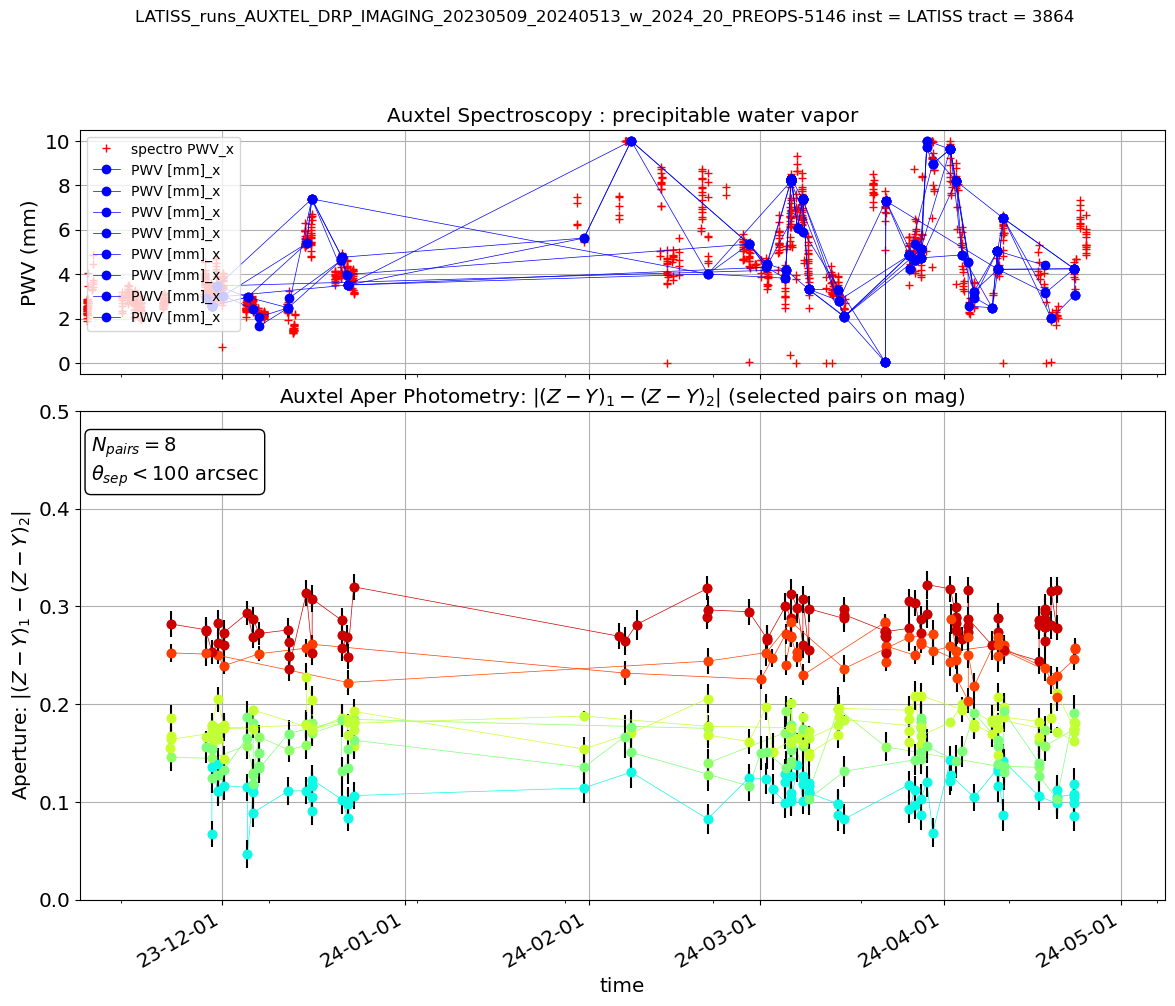

In [61]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,10),constrained_layout=True)
gs = GridSpec(2, 1, wspace=0, hspace=0.1, height_ratios=[1,2],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)


df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    if idx in good_indexes:
        df_col.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
        #ax2.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,ecolor="k",fmt="o")
        ax2.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

        df_col.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker="o",c="b",lw=0.5,grid=True,legend=False)
        
        tmin = df_col["time1"].min()
        tmax = df_col["time1"].max()
        dt = tmax-tmin
        tmin = tmin-dt/10
        tmax = tmax+dt/10
        all_tmin.append(tmin)
        all_tmax.append(tmax)

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax2.set_xlim(the_tmin,the_tmax)
ax2.set_title("Auxtel Aper Photometry: $|(Z-Y)_1-(Z-Y)_2|$ (selected pairs on mag)")
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax1.set_title("Auxtel Spectroscopy : precipitable water vapor")
#ax2.legend(loc="upper left")
ax2.set_ylabel("Aperture: $|(Z-Y)_1-(Z-Y)_2|$")
ax2.set_ylim(0.,0.5)
ax2.text(0.01, 0.95, textstr0, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)

title = suptitle
plt.suptitle(title,y=1)
plt.tight_layout()

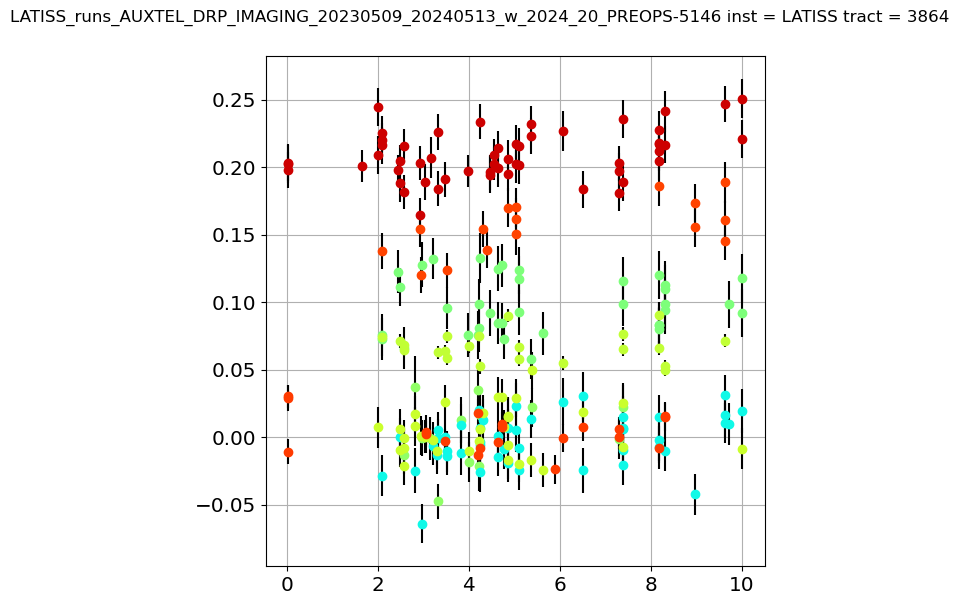

In [62]:

fig,ax  = plt.subplots(figsize=(6,6))


for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

   

    if idx in good_indexes:
        refcol_ap_md = df_summary.loc[idx,"refcol_ap_md"]
        #df_col.plot(x="PWV [mm]_x",y="apcol12_s12",ax=ax,marker="o",c=the_color,lw=0.5,grid=True,legend=False)
        #ax2.errorbar(df_col.time1,df_col.psfcol12_s12,yerr=df_col.psfcol12Err_s12,color=the_color,ecolor="k",fmt="o")
        ax.errorbar(df_col["PWV [mm]_x"],df_col.apcol12_s12-refcol_ap_md,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")
        
ax.grid()       
title = suptitle
plt.suptitle(title,y=1)
plt.tight_layout()

## Loop to plot relative light curves one by one

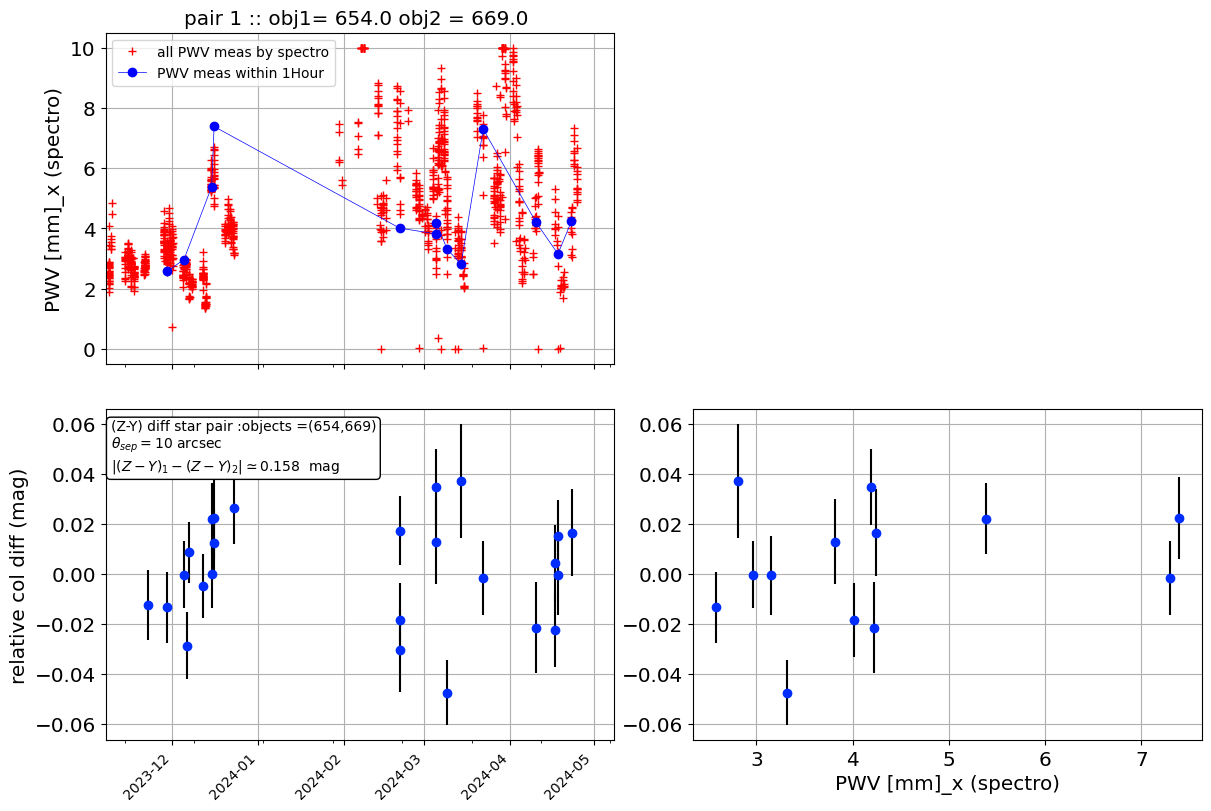

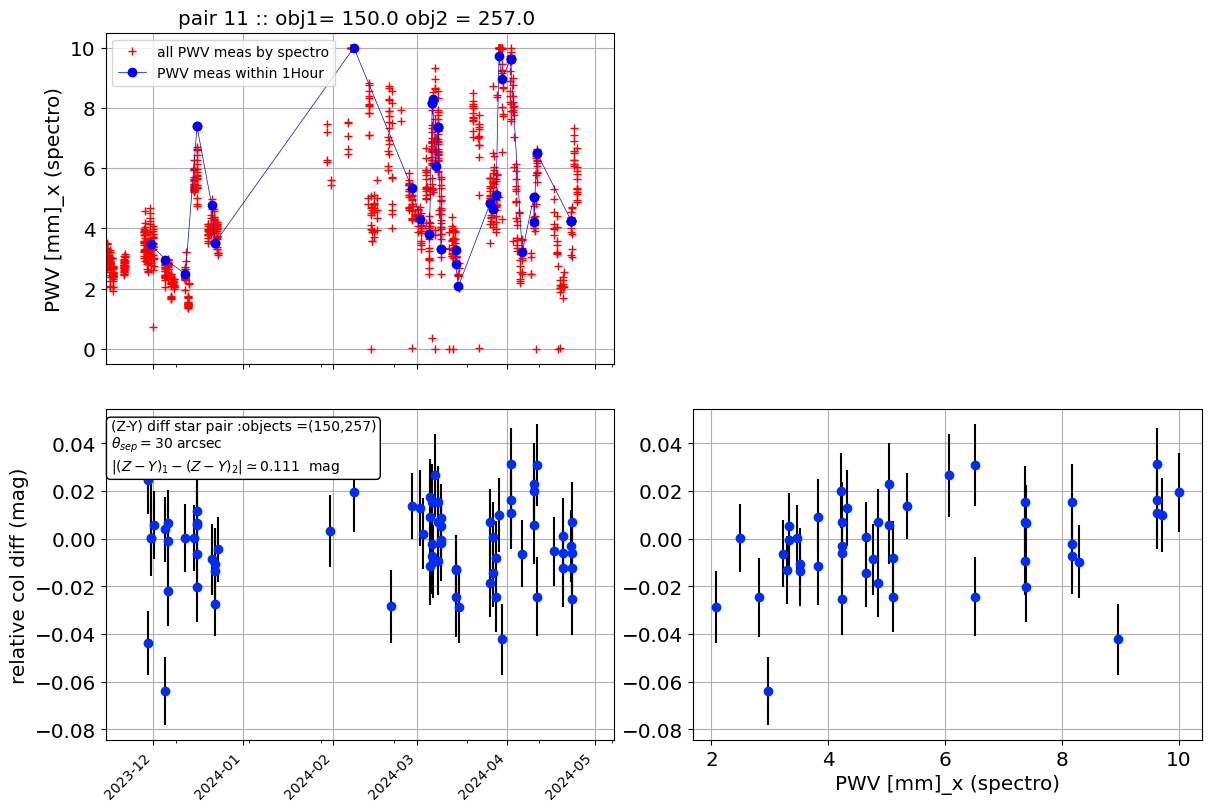

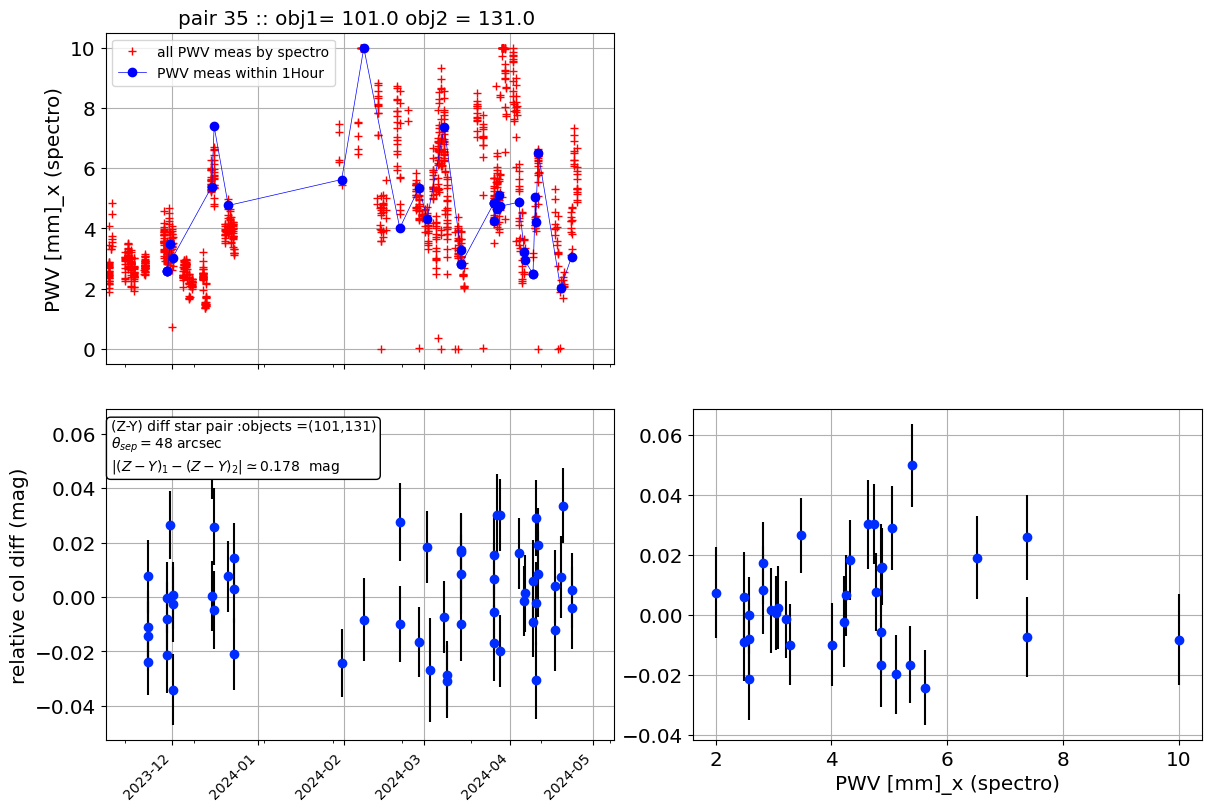

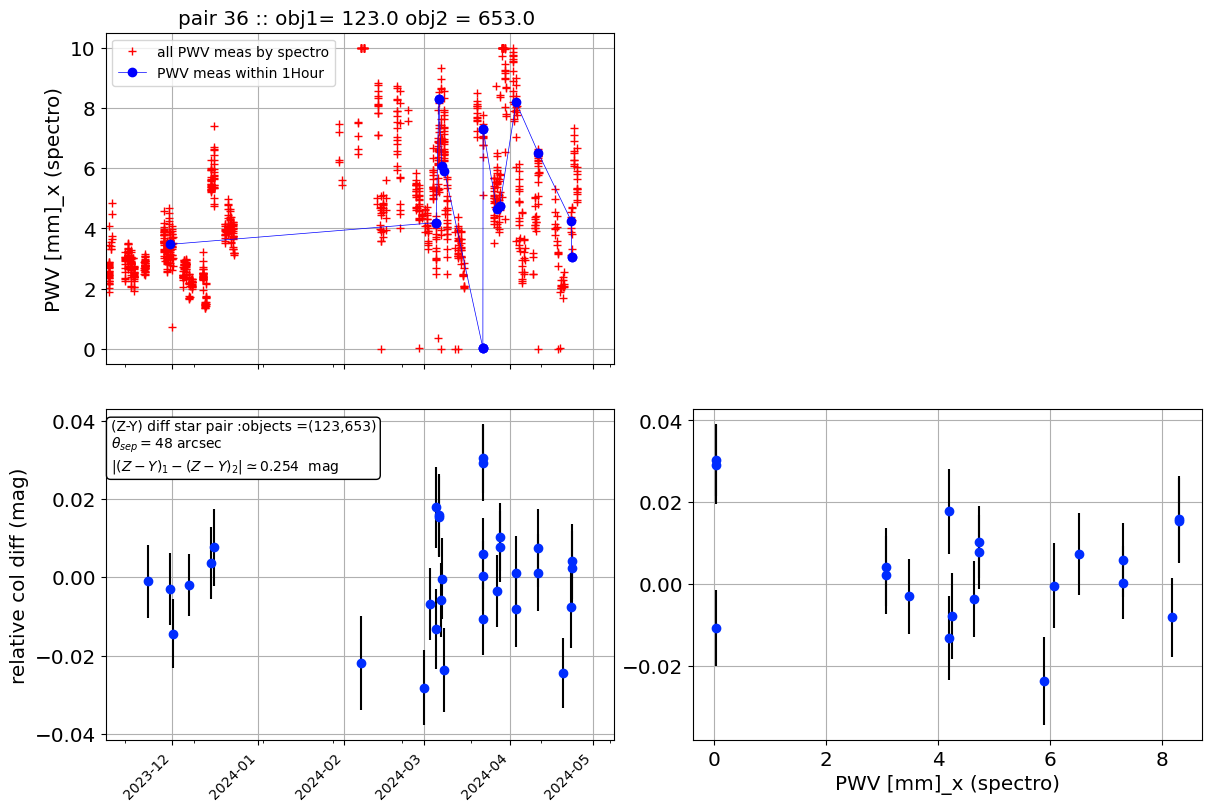

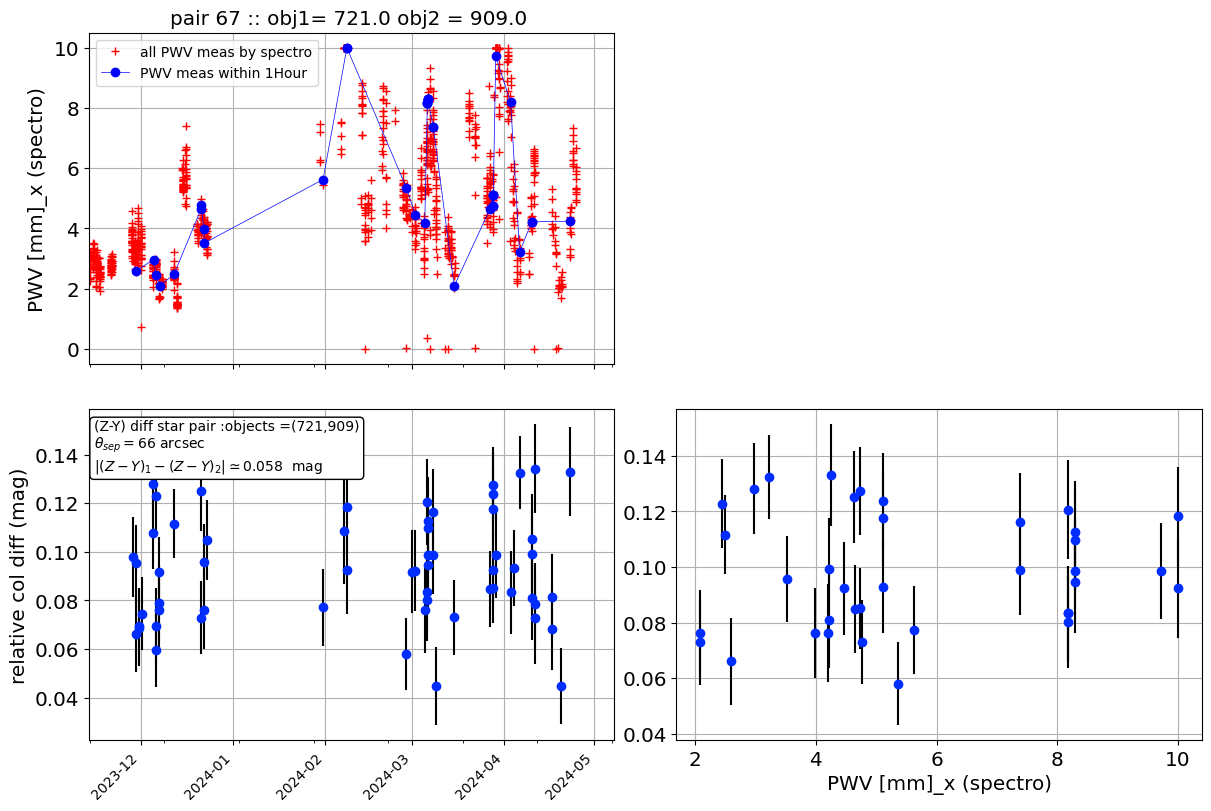

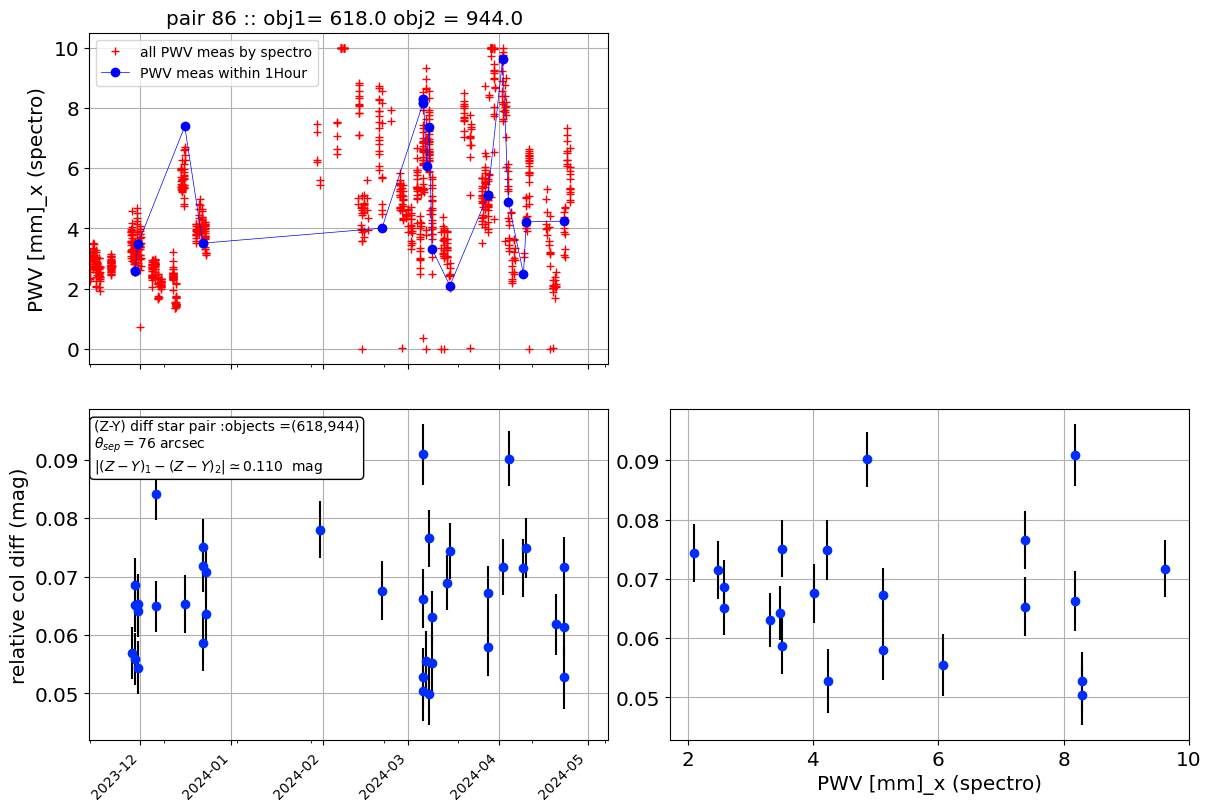

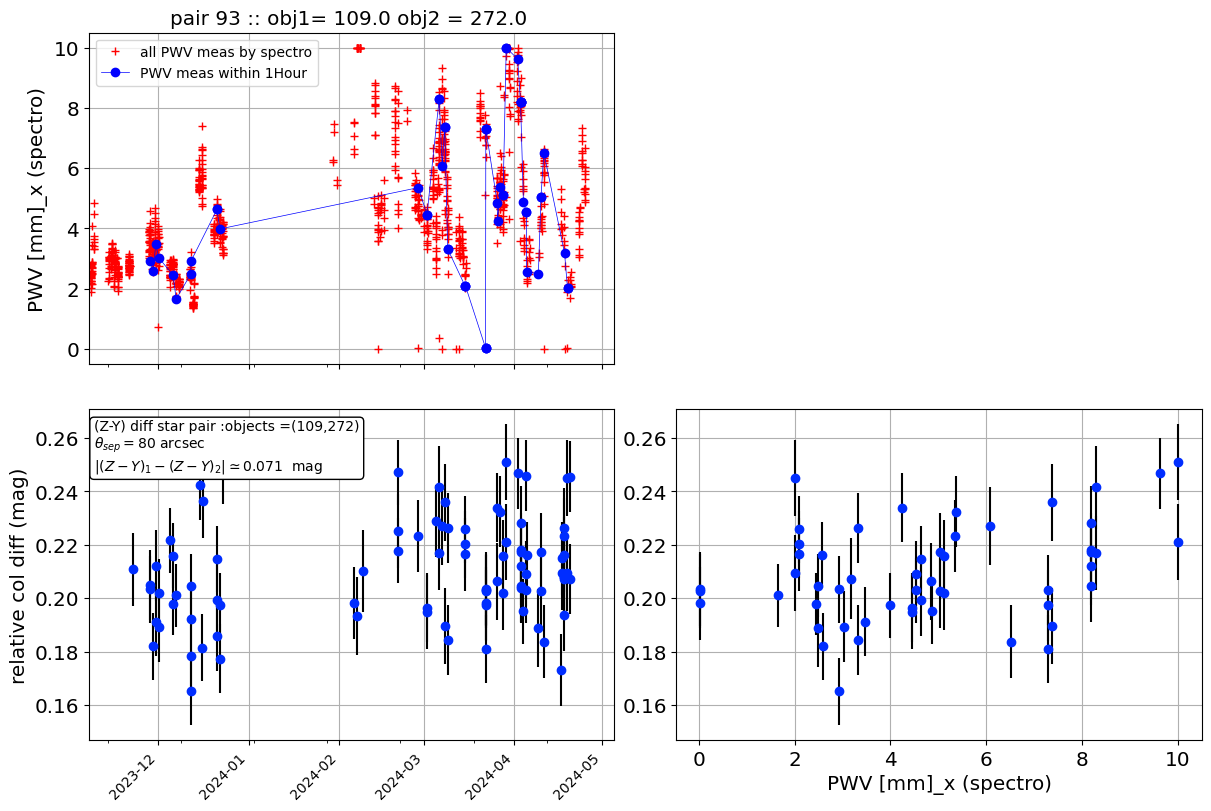

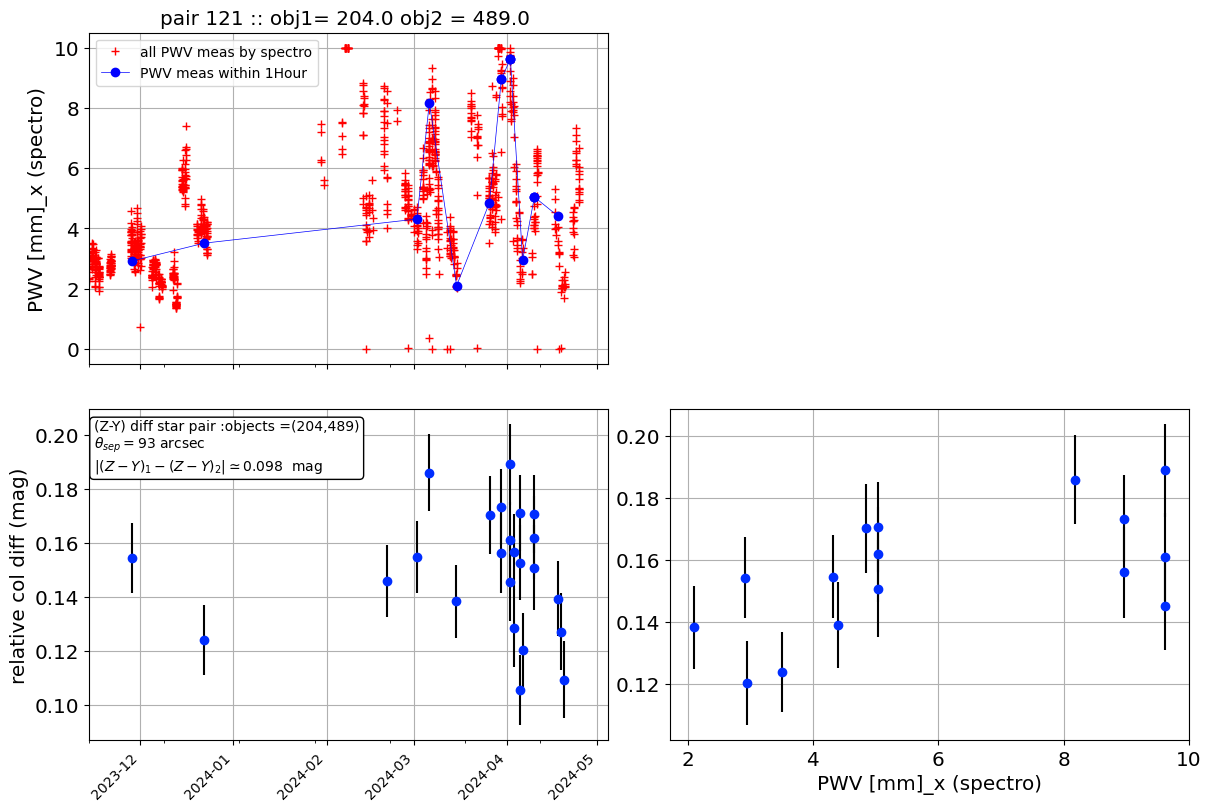

In [68]:
date_form = DateFormatter("%y-%m-%d")

for good_idx in good_indexes:

    fig = plt.figure(figsize=(12,8),constrained_layout=True)
    gs = GridSpec(2, 2, wspace=0, hspace=0.1, height_ratios=[1,1],figure=fig)

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
    ax4 = fig.add_subplot(gs[1,1])

    df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="all PWV meas by spectro")


    # get the light curve
    df_col = all_colors_diff[good_idx]
    refcol_ap_md = df_summary.loc[good_idx,"refcol_ap_md"]

    textstr = '\n'.join((
    "(Z-Y) diff star pair :"
    r'objects =(%.0f,%.0f)' % (df_summary.loc[good_idx,"idx_obj1"],df_summary.loc[good_idx,"idx_obj2"],  ),
    r'$\theta_{sep} = %.0f$ arcsec' % (df_summary.loc[good_idx,"sep"], ),
    r'$|(Z-Y)_1- (Z-Y)_2| \simeq%.3f$  mag' % (df_summary.loc[good_idx,"refcol_ap_md"], )))

    title = "pair {} :: obj1= {} obj2 = {} ".format(good_idx,df_summary.loc[good_idx,"idx_obj1"],df_summary.loc[good_idx,"idx_obj2"])
    ax1.set_title(title)
    ax1.set_ylabel("PWV [mm]_x (spectro)")
    
    ax2.errorbar(df_col.time1,df_col.apcol12_s12-refcol_ap_md,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")
    df_col.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker="o",c="b",lw=0.5,grid=True,label="PWV meas within 1Hour")
    ax2.text(0.01, 0.97, textstr, transform=ax2.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    ax2.set_ylabel("relative col diff (mag)")
    
    ax4.errorbar(df_col["PWV [mm]_x"],df_col.apcol12_s12-refcol_ap_md,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")
    ax4.grid()
    ax4.set_xlabel("PWV [mm]_x (spectro)")
    
    tmin = df_col["time1"].min()
    tmax = df_col["time1"].max()
    dt = tmax-tmin
    tmin = tmin-dt/10
    tmax = tmax+dt/10

    the_tmin=tmin
    the_tmax=tmax

    ax2.set_xlim(the_tmin,the_tmax)
    ax2.grid()
    #plt.xticks(rotation=45)
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right',fontsize=10)
